In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

In [263]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, activation='relu'):
        super().__init__()
        layers = []

        if activation == 'relu':
            activation_function = nn.ReLU
        elif activation == 'tanh':
            activation_function = nn.Tanh
        elif activation == 'elu':
            activation_function = nn.ELU
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation_function())
        
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_function())
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))  # output size is 1
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [3]:
def train_to_convergence(model,
                         x_train,
                         y_train,
                         optimizer,
                         criterion,
                         loss_threshold=0.01,
                         max_epochs=1000):
    
    #pbar = tqdm(range(max_epochs), desc="Training", unit="epoch")
    #for epoch in pbar:
    for epoch in range(max_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        if loss.item() < loss_threshold:
            break

        loss.backward()
        optimizer.step()
        
        # Update progress bar description
        #bar.set_postfix(loss=loss.item())


In [28]:
class ParityDataset:

    def __init__(self, dim=4, p_new=0.5):

        self.dim = dim
        self.p_new = p_new

        self.x_list = []
        self.y_class_list = []
        self.y_new_list = []
        self.y_know_list = []

        self.keys = set()
        
        self.curr_idx = None 

    def generate_sample(self):

        if len(self.x_list) == 0 or random.random() < self.p_new:

            x = torch.randint(0, 2, (self.dim,), dtype=torch.float32)
            key = tuple(x.tolist())
            while key in self.keys:
                x = torch.randint(0, 2, (self.dim,), dtype=torch.float32)
                key = tuple(x.tolist())
            self.keys.add(key)
            
            y_class = (x.sum() % 2).item()

            y_new = 1

            self.x_list.append(x)
            self.y_class_list.append(y_class)
            self.y_new_list.append(y_new)

            self.curr_idx = len(self.x_list) - 1
            self.y_know_list.append(None)
        
        else:

            idx = np.random.randint(low=0, high=len(self.x_list))
            x = self.x_list[idx]
            y_class = self.y_class_list[idx]
            y_new = 0
            self.y_new_list[idx] = y_new
            self.curr_idx = idx

        return x.unsqueeze(0), torch.tensor([y_class, y_new])

    def update_know(self, know):

        self.y_know_list[self.curr_idx] = know
    
    def get_train(self):

        x_tensor = torch.stack(self.x_list, dim=0)
        y_class_tensor = torch.tensor(self.y_class_list, dtype=torch.float32).unsqueeze(1)
        y_new_tensor = torch.tensor(self.y_new_list, dtype=torch.float32).unsqueeze(1)
        y_know_tensor = torch.tensor(self.y_know_list, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.cat((y_class_tensor, y_new_tensor, y_know_tensor), dim=1)

        return x_tensor, y_tensor

In [30]:
dataset = ParityDataset(5)
for i in range(10):
    x, y = dataset.generate_sample()
    print(x, y)

tensor([[0., 0., 1., 0., 0.]]) tensor([1., 1.])
tensor([[0., 0., 0., 0., 0.]]) tensor([0., 1.])
tensor([[1., 0., 0., 0., 1.]]) tensor([0., 1.])
tensor([[0., 0., 1., 0., 0.]]) tensor([1., 0.])
tensor([[0., 0., 1., 0., 0.]]) tensor([1., 0.])
tensor([[1., 0., 1., 1., 1.]]) tensor([0., 1.])
tensor([[1., 1., 0., 0., 1.]]) tensor([1., 1.])
tensor([[1., 0., 1., 1., 1.]]) tensor([0., 0.])
tensor([[0., 1., 1., 1., 0.]]) tensor([1., 1.])
tensor([[1., 1., 0., 0., 1.]]) tensor([1., 0.])


In [110]:
#
# Training Loop
#

# Hyperparameters
n_iterations = 100
input_dim = 11
output_dim = 3
hidden_dim = 1024
n_layers = 1
loss_threshold = 0.01  # stop training when loss falls below this
max_epochs = 1000
learning_rate = 1e-3
weight_decay = 0
activation = 'relu'
criterion_name = 'mae'
if criterion_name == 'mse':
    criterion = nn.MSELoss()
elif criterion_name == 'mae':
    criterion = nn.L1Loss()
elif criterion_name == 'log_loss':
    criterion = nn.BCEWithLogitsLoss()

# Initialize model and optimizer (should it/they be reoptimized every time?)
model = FFNN(input_dim, hidden_dim, output_dim, n_layers, activation)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset
dataset = ParityDataset(dim=input_dim)

# Initialize record-keeping
class_true = []
class_pred = []
new_true = []
new_pred = []
know_true = []
know_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Encounter new sample
    x, y = dataset.generate_sample()
    class_true.append(y[0].item())
    new_true.append(y[1].item())

    # Collect prediction
    model.eval()
    with torch.no_grad():
        pred = model(x)
        class_pred.append(pred[0][0].item())
        new_pred.append(pred[0][1].item())
        know_pred.append(pred[0][2].item())
        know = ((class_pred[-1] > 0.5) == class_true[-1])
        know_true.append(know)
        dataset.update_know(know)

    # Update model
    x_train, y_train = dataset.get_train()
    train_to_convergence(model, x_train, y_train, 
                         optimizer, criterion,
                         loss_threshold=loss_threshold)
    

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.95it/s]


In [111]:
# Train meta-model with same parameters

meta_input_dim = 3
meta_loss_threshold = 0.01

# Initialize model and optimizer
meta_model = FFNN(meta_input_dim, hidden_dim, output_dim, n_layers, activation)
meta_optimizer = optim.Adam(meta_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset

class_pred_tensor = torch.tensor(class_pred, dtype=torch.float32).unsqueeze(1)
new_pred_tensor = torch.tensor(new_pred, dtype=torch.float32).unsqueeze(1)
know_pred_tensor = torch.tensor(know_pred, dtype=torch.float32).unsqueeze(1)
meta_x_train = torch.cat((class_pred_tensor, new_pred_tensor, know_pred_tensor), dim=1)

#meta_x_train = torch.cat((base_model_output_train, x_train), dim=1)

class_true_tensor = torch.tensor(class_true, dtype=torch.float32).unsqueeze(1)
new_true_tensor = torch.tensor(new_true, dtype=torch.float32).unsqueeze(1)
know_true_tensor = torch.tensor(know_true, dtype=torch.float32).unsqueeze(1)
meta_y_train = torch.cat((class_true_tensor, new_true_tensor, know_true_tensor), dim=1)

# Initialize record-keeping
meta_class_pred = []
meta_new_pred = []
meta_know_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Collect prediction
    meta_model.eval()
    with torch.no_grad():
        meta_pred = meta_model(meta_x_train[iteration])
        meta_class_pred.append(meta_pred[0].item())
        meta_new_pred.append(meta_pred[1].item())
        meta_know_pred.append(meta_pred[2].item())
        
    # Get current data set
    x_train = meta_x_train[:iteration + 1]
    y_train = meta_y_train[:iteration + 1]

    # Update meta-model
    train_to_convergence(meta_model, x_train, y_train, meta_optimizer, criterion, loss_threshold=meta_loss_threshold)    

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.10it/s]


In [112]:
# Compute accuracy of base model and meta-model
def accuracy(true, preds, threshold=0.5):
    return (true == (np.array(preds) > threshold)).mean()

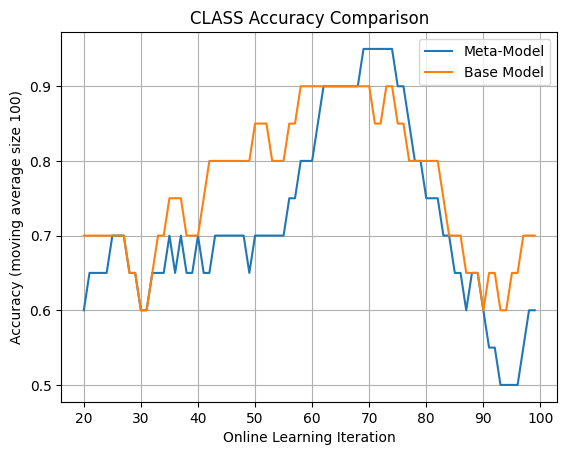

In [114]:
# Plot accuracies over time
for threshold in [0.5]:
    window_size = 20
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(class_true)):
        base_accs.append(accuracy(class_true[i-window_size:i], class_pred[i-window_size:i]))
        meta_accs.append(accuracy(class_true[i-window_size:i], meta_class_pred[i-window_size:i], threshold))
    
    plt.plot(np.arange(window_size, len(class_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(class_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"CLASS Accuracy Comparison")
    plt.grid()
    plt.show()

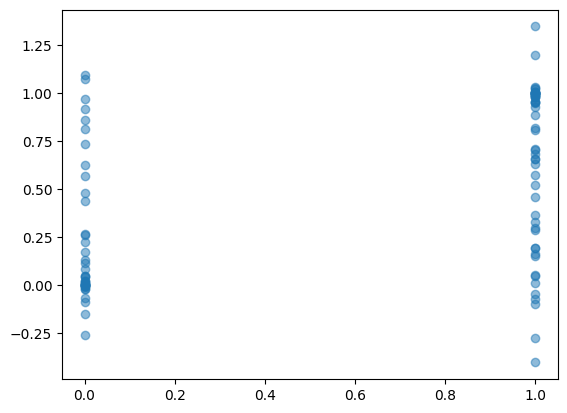

In [109]:
plt.scatter(class_true, meta_class_pred, alpha=0.5)
# Maybe this one relies on a specific fixed pre-trained model. Which could even be an advantage

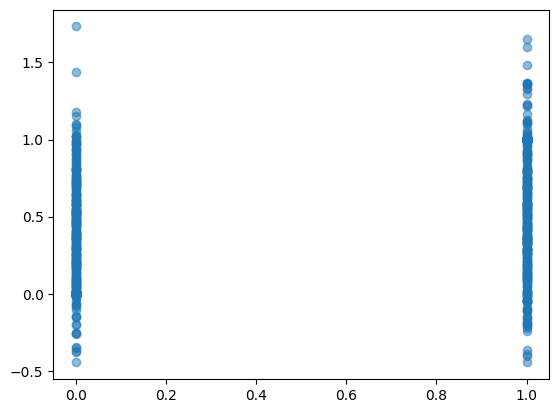

In [42]:
plt.scatter(class_true, class_pred, alpha=0.5)

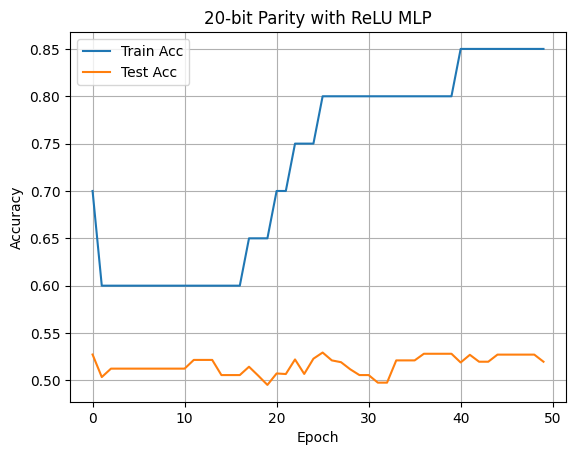

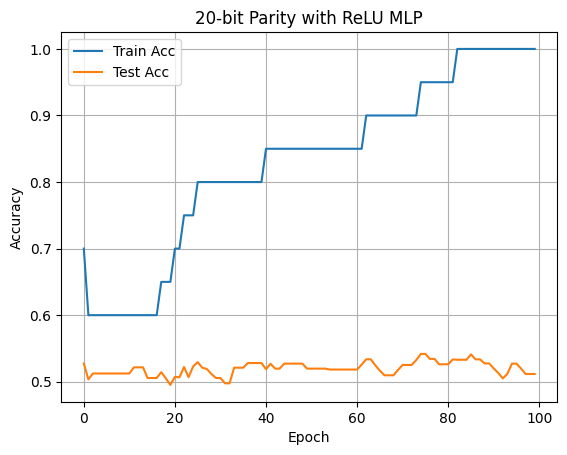

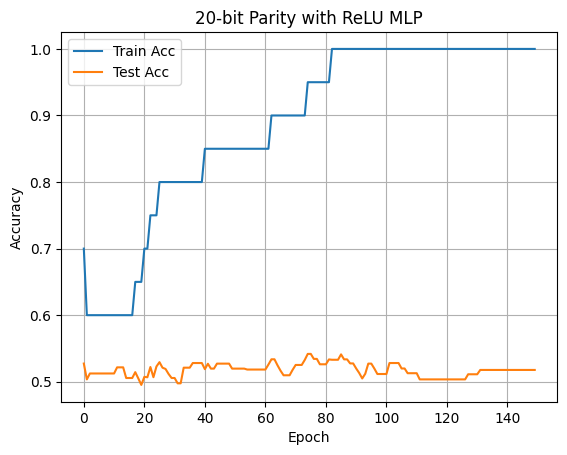

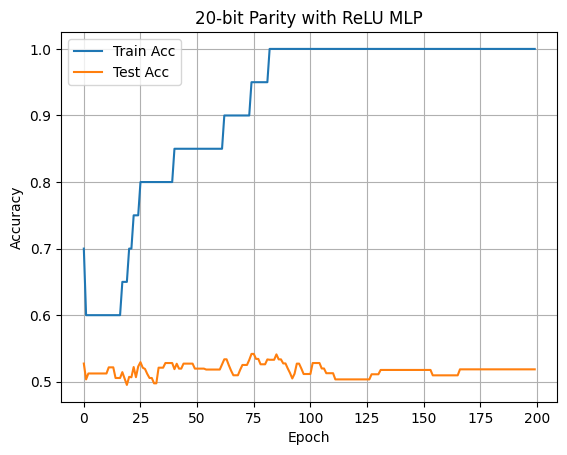

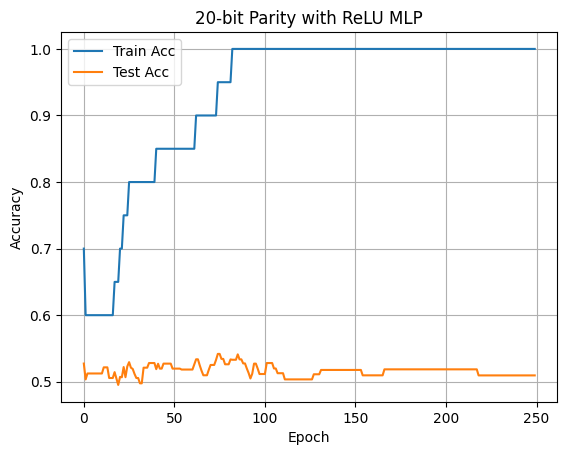

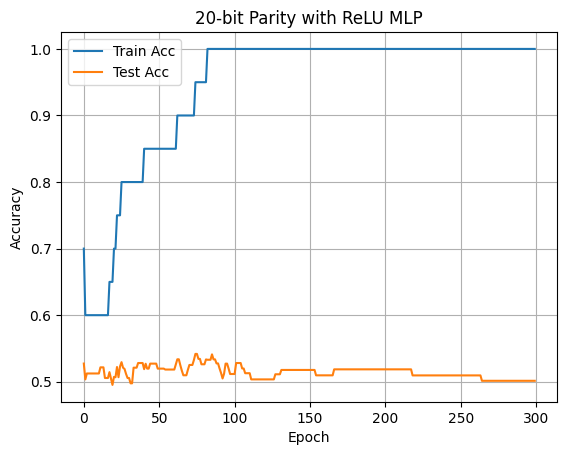

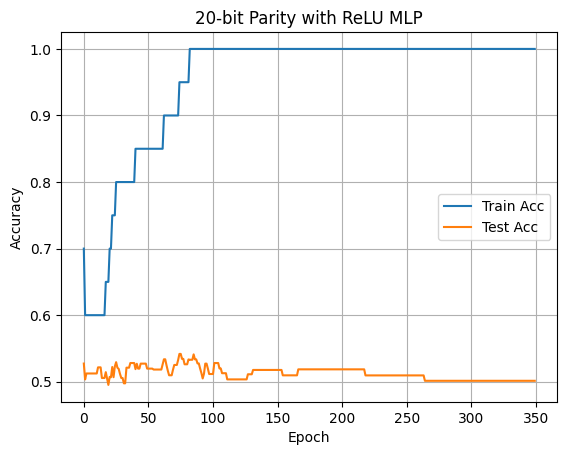

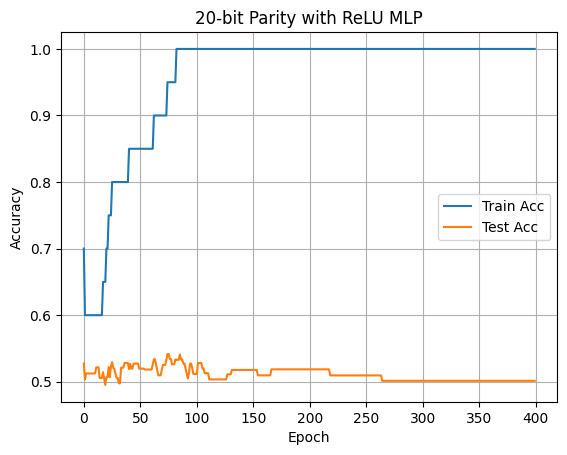

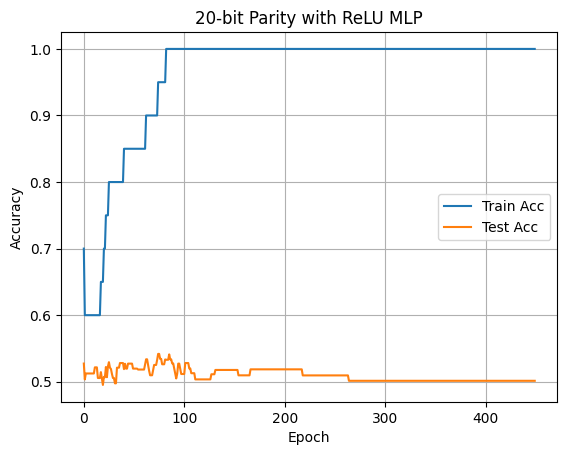

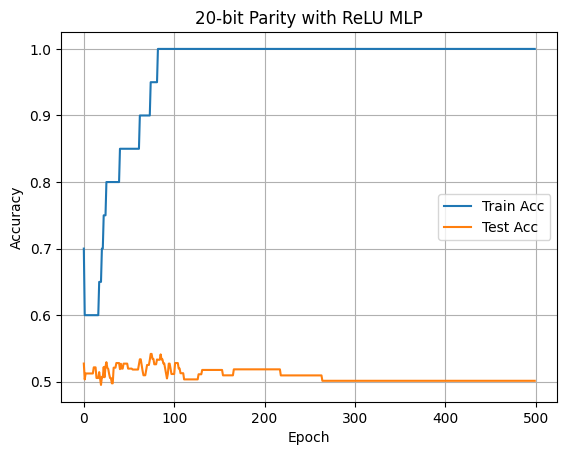

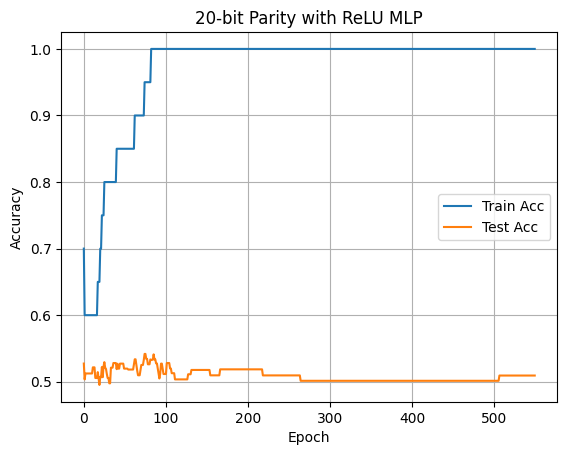

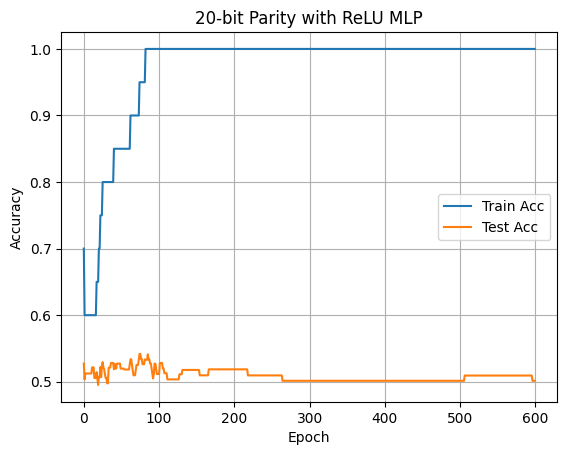

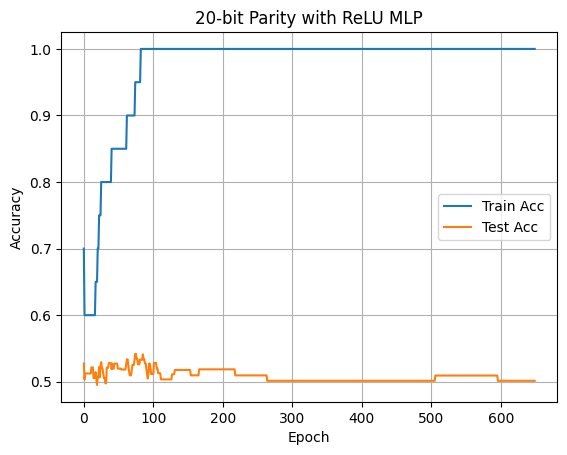

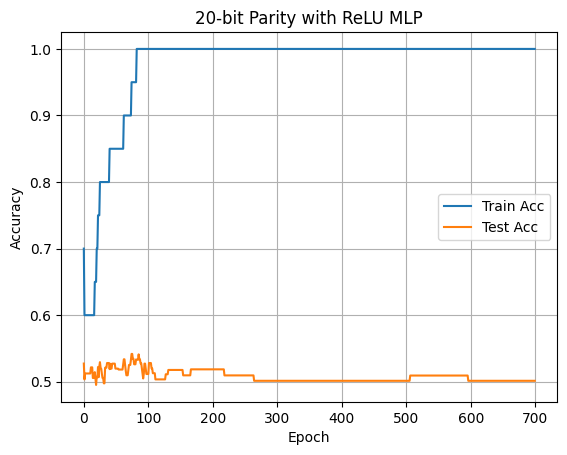

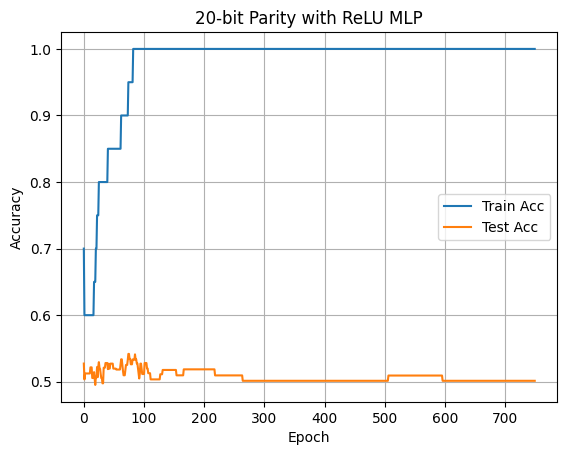

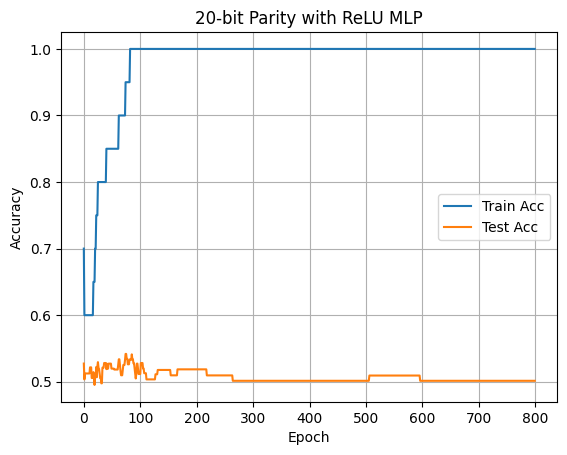

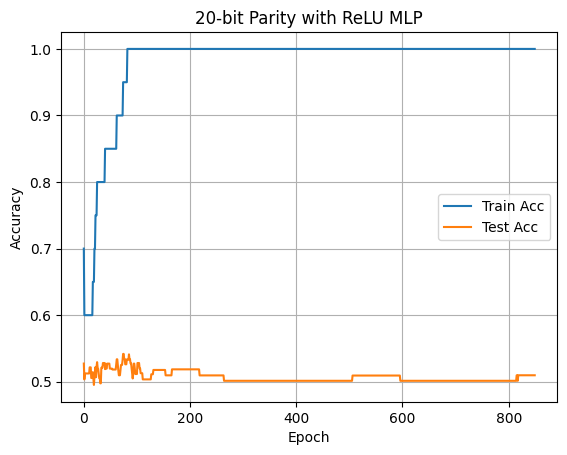

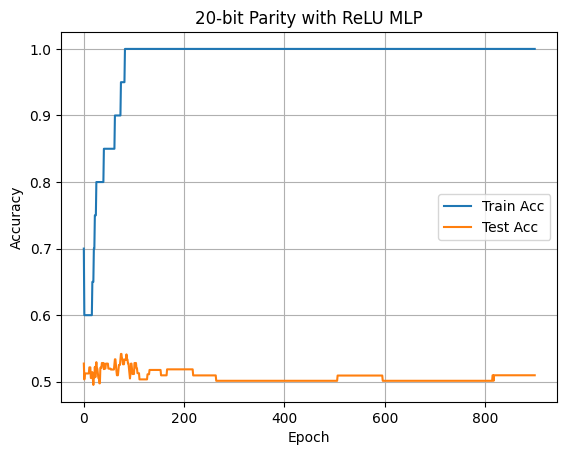

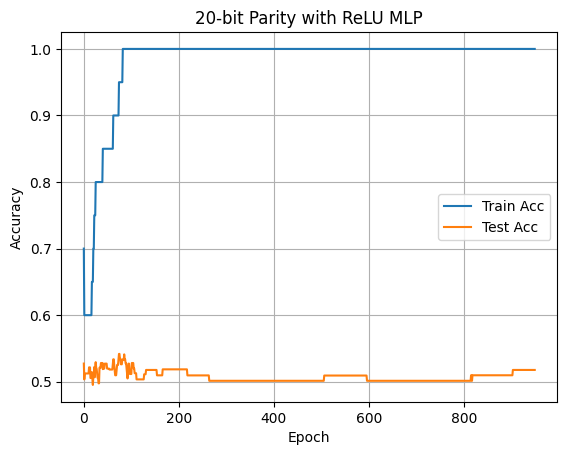

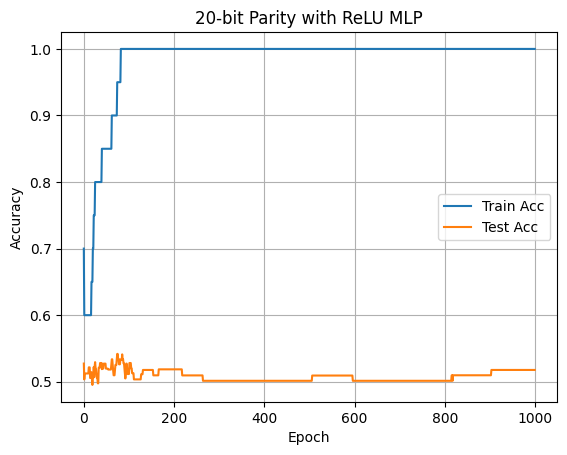

In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate random 20-bit binary inputs
n_bits = 7
n_train = 20
n_test = 10000

X = torch.randint(0, 2, (n_train + n_test, n_bits)).float()
y = (X.sum(dim=1) % 2).view(-1, 1).float()

X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

# Define the model
class ParityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bits, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = ParityNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Training loop
train_accs, test_accs = [], []
for epoch in range(1000):
    model.train()
    perm = torch.randperm(n_train)
    for i in range(0, n_train, 32):
        idx = perm[i:i+32]
        batch_x, batch_y = X_train[idx], y_train[idx]
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_preds = (model(X_train) > 0.5).float()
        test_preds = (model(X_test) > 0.5).float()
        train_accs.append((train_preds == y_train).float().mean().item())
        test_accs.append((test_preds == y_test).float().mean().item())

    if (epoch + 1) % 50 == 0:
        # Plot
        plt.plot(train_accs, label="Train Acc")
        plt.plot(test_accs, label="Test Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("20-bit Parity with ReLU MLP")
        plt.grid(True)
        plt.legend()
        plt.show()


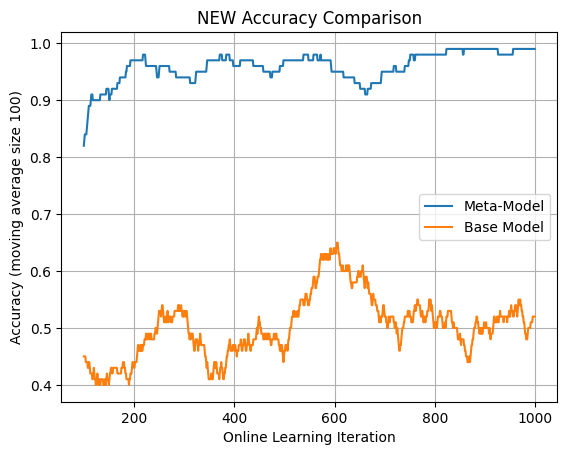

In [43]:
# Plot accuracies over time
for threshold in [0.5]:
    window_size = 100
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(class_true)):
        base_accs.append(accuracy(new_true[i-window_size:i], new_pred[i-window_size:i]))
        meta_accs.append(accuracy(new_true[i-window_size:i], meta_new_pred[i-window_size:i], threshold))
    
    plt.plot(np.arange(window_size, len(new_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(new_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"NEW Accuracy Comparison")
    plt.grid()
    plt.show()

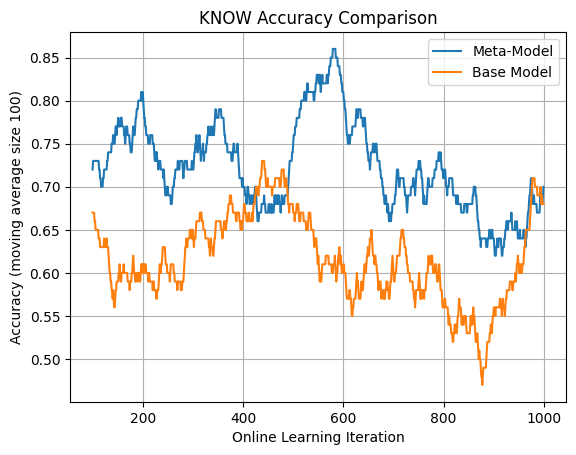

In [44]:
# Plot accuracies over time
for threshold in [0.5]:
    window_size = 100
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(know_true)):
        base_accs.append(accuracy(know_true[i-window_size:i], know_pred[i-window_size:i]))
        meta_accs.append(accuracy(know_true[i-window_size:i], meta_know_pred[i-window_size:i], threshold))
    
    plt.plot(np.arange(window_size, len(know_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(know_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title(f"KNOW Accuracy Comparison")
    plt.grid()
    plt.show()

Test accuracy: 0.49


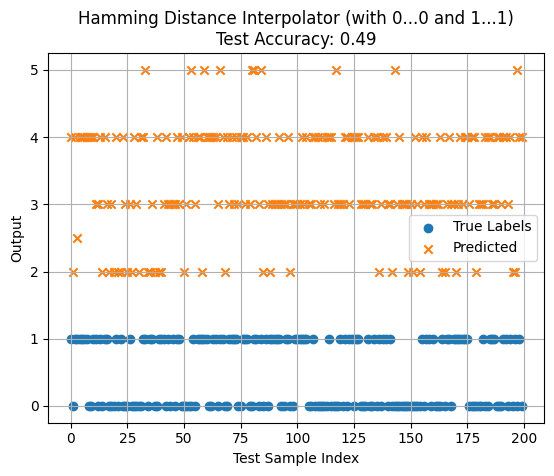

In [101]:
import torch
import matplotlib.pyplot as plt

# Parameters
n_bits = 7
n_train = 10
n_test = 200

# Manually include all-zeros and all-ones
X_manual = torch.stack([torch.zeros(n_bits), torch.ones(n_bits)]).float()
y_manual = (X_manual.sum(dim=1) % 2).view(-1, 1).float()

# Random remaining training data
X_random = torch.randint(0, 2, (n_train - 2, n_bits)).float()
y_random = (X_random.sum(dim=1) % 2).view(-1, 1).float()

# Combine full training set
X_train = torch.cat([X_manual, X_random], dim=0)
y_train = torch.cat([y_manual, y_random], dim=0)

# Generate test set
X_test = torch.randint(0, 2, (n_test, n_bits)).float()
y_test = (X_test.sum(dim=1) % 2).view(-1, 1).float()

# Hamming distance embedding
def hamming_embedding(X, X_ref):
    return torch.cdist(X, X_ref, p=1)

# Train embedding and interpolation
Phi_train = hamming_embedding(X_train, X_train)
W = torch.pinverse(Phi_train) @ y_train

# Test predictions
with torch.no_grad():
    Phi_test = hamming_embedding(X_test, X_train)
    y_pred_test = Phi_test @ W
    y_class_test = (y_pred_test > 0.5).float()
    test_acc = (y_class_test == y_test).float().mean().item()
    print(f"Test accuracy: {test_acc:.2f}")

# Plot
plt.scatter(range(n_test), y_test.numpy(), label='True Labels', marker='o')
plt.scatter(range(n_test), y_pred_test.numpy(), label='Predicted', marker='x')
plt.title(f'Hamming Distance Interpolator (with 0...0 and 1...1)\nTest Accuracy: {test_acc:.2f}')
plt.xlabel('Test Sample Index')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()


Test accuracy: 0.46


/var/folders/l5/bnxhb0d55rg_wsbyxwcclhfr0000gq/T/ipykernel_89097/3905638810.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


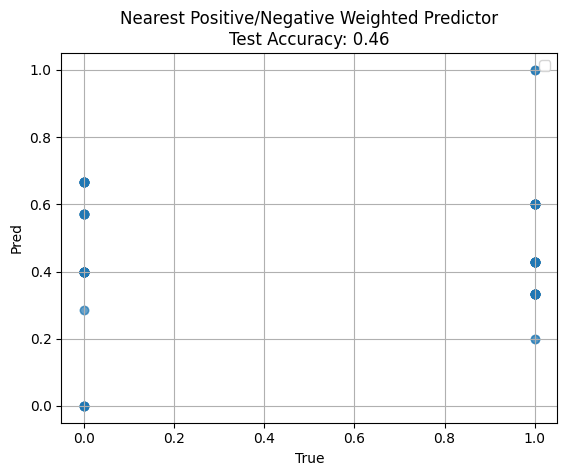

In [90]:
import torch
import matplotlib.pyplot as plt

# Settings
n_bits = 5
n_train = 3
n_test = 200
epsilon = 0

# Generate parity-labeled data
X_train = torch.randint(0, 2, (n_train, n_bits)).float()
y_train = (X_train.sum(dim=1) % 2).view(-1, 1).float()

X_test = torch.randint(0, 2, (n_test, n_bits)).float()
y_test = (X_test.sum(dim=1) % 2).view(-1, 1).float()

# Split training set
X_pos = X_train[y_train.view(-1) == 1]
X_neg = X_train[y_train.view(-1) == 0]

# Predictor: weighted inverse of Hamming distances
def predict_weighted_nn(X_test, X_pos, X_neg, eps=1e-5):
    d_pos = torch.cdist(X_test, X_pos, p=1).min(dim=1).values
    d_neg = torch.cdist(X_test, X_neg, p=1).min(dim=1).values
    w_pos = 1 / (d_pos + eps)
    w_neg = 1 / (d_neg + eps)
    return (w_pos / (w_pos + w_neg)).view(-1, 1)

# Run prediction
with torch.no_grad():
    y_pred = predict_weighted_nn(X_test, X_pos, X_neg)
    y_class = (y_pred > 0.5).float()
    acc = (y_class == y_test).float().mean().item()
    print(f"Test accuracy: {acc:.2f}")

# Plot predictions vs true labels
plt.scatter(y_test.numpy(), y_pred.numpy(), alpha=0.25)
plt.title(f'Nearest Positive/Negative Weighted Predictor\nTest Accuracy: {acc:.2f}')
plt.xlabel('True')
plt.ylabel('Pred')
plt.legend()
plt.grid(True)
plt.show()


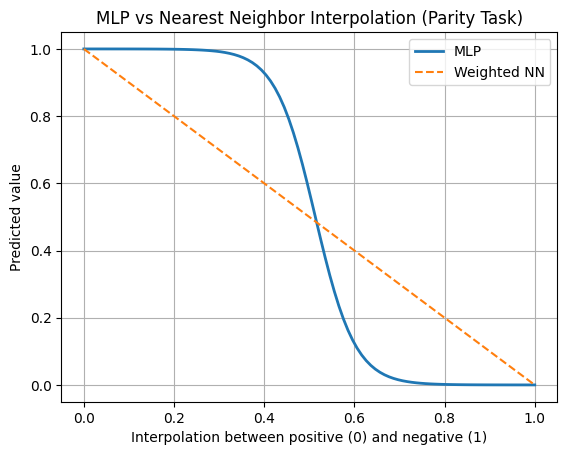

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Setup
torch.manual_seed(0)
n_bits = 7
hidden_dim = 64
n_epochs = 1000
lr = 0.01

# Create a positive and a negative training example from parity
x_pos = torch.randint(0, 2, (n_bits,), dtype=torch.float32)
x_neg = 1 - x_pos  # Flip bits to get opposite parity

y_pos = torch.tensor([x_pos.sum().item() % 2], dtype=torch.float32)
y_neg = torch.tensor([x_neg.sum().item() % 2], dtype=torch.float32)

X_train = torch.stack([x_pos, x_neg])
y_train = torch.stack([y_pos, y_neg]).view(-1, 1)

# MLP definition
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = SimpleMLP(n_bits, hidden_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train to perfect fit
for _ in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

# Interpolation path between x_pos and x_neg
alphas = torch.linspace(0, 1, 100)
interp_points = torch.stack([(1-a)*x_pos + a*x_neg for a in alphas])

# MLP predictions
model.eval()
with torch.no_grad():
    mlp_preds = model(interp_points).view(-1)

# Nearest-neighbor interpolation (weighted inverse distance)
d_pos = torch.norm(interp_points - x_pos, p=1, dim=1)
d_neg = torch.norm(interp_points - x_neg, p=1, dim=1)
w_pos = 1 / (d_pos + 1e-5)
w_neg = 1 / (d_neg + 1e-5)
nn_preds = (w_pos / (w_pos + w_neg)).view(-1)

# Plot
plt.plot(alphas, mlp_preds, label="MLP", linewidth=2)
plt.plot(alphas, nn_preds, label="Weighted NN", linestyle="--")
plt.xlabel("Interpolation between positive (0) and negative (1)")
plt.ylabel("Predicted value")
plt.title("MLP vs Nearest Neighbor Interpolation (Parity Task)")
plt.grid(True)
plt.legend()
plt.show()


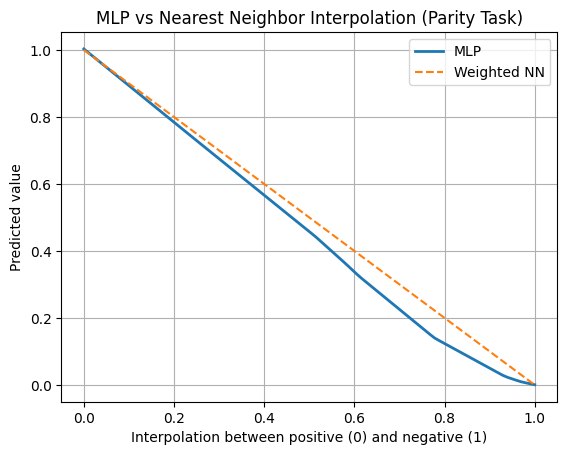

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Setup
torch.manual_seed(0)
n_bits = 7
hidden_dim = 64
n_epochs = 1000
lr = 0.01

# Create a positive and a negative training example from parity
x_pos = torch.randint(0, 2, (n_bits,), dtype=torch.float32)
x_neg = 1 - x_pos  # Flip bits to get opposite parity

y_pos = torch.tensor([x_pos.sum().item() % 2], dtype=torch.float32)
y_neg = torch.tensor([x_neg.sum().item() % 2], dtype=torch.float32)

X_train = torch.stack([x_pos, x_neg])
y_train = torch.stack([y_pos, y_neg]).view(-1, 1)

# MLP definition
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = SimpleMLP(n_bits, hidden_dim)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train to perfect fit
for _ in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

# Interpolation path between x_pos and x_neg
alphas = torch.linspace(0, 1, 100)
interp_points = torch.stack([(1-a)*x_pos + a*x_neg for a in alphas])

# MLP predictions
model.eval()
with torch.no_grad():
    mlp_preds = model(interp_points).view(-1)

# Nearest-neighbor interpolation (weighted inverse distance)
d_pos = torch.norm(interp_points - x_pos, p=1, dim=1)
d_neg = torch.norm(interp_points - x_neg, p=1, dim=1)
w_pos = 1 / (d_pos + 1e-5)
w_neg = 1 / (d_neg + 1e-5)
nn_preds = (w_pos / (w_pos + w_neg)).view(-1)

# Plot
plt.plot(alphas, mlp_preds, label="MLP", linewidth=2)
plt.plot(alphas, nn_preds, label="Weighted NN", linestyle="--")
plt.xlabel("Interpolation between positive (0) and negative (1)")
plt.ylabel("Predicted value")
plt.title("MLP vs Nearest Neighbor Interpolation (Parity Task)")
plt.grid(True)
plt.legend()
plt.show()


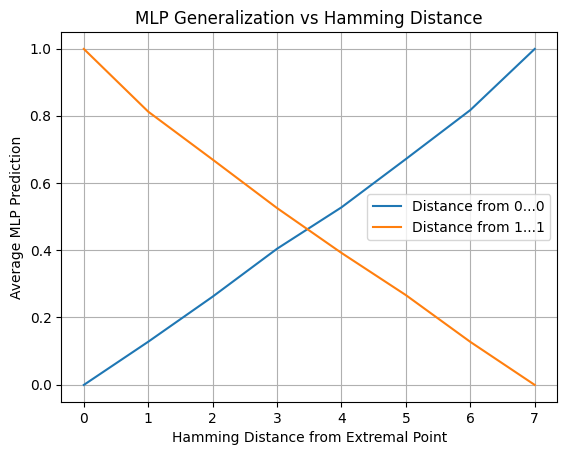

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Setup
torch.manual_seed(0)
n_bits = 7
hidden_dim = 64
n_epochs = 10000
lr = 0.001

# All-zeros and all-ones inputs
x_zeros = torch.zeros(n_bits)
x_ones = torch.ones(n_bits)
y_zeros = torch.tensor([x_zeros.sum() % 2], dtype=torch.float32)
y_ones = torch.tensor([x_ones.sum() % 2], dtype=torch.float32)

X_train = torch.stack([x_zeros, x_ones])
y_train = torch.stack([y_zeros, y_ones]).view(-1, 1)

# Define simple MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = SimpleMLP(n_bits, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.L1Loss()

# Train
for _ in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()

# Generate samples at specific Hamming distances
def sample_at_distance(x_ref, dist, n_samples):
    samples = []
    for _ in range(n_samples):
        idx = torch.randperm(n_bits)[:dist]
        x = x_ref.clone()
        x[idx] = 1 - x[idx]  # flip bits
        samples.append(x)
    return torch.stack(samples)

# Measure prediction as function of distance
distances = list(range(0, n_bits + 1))
preds_from_zeros = []
preds_from_ones = []

model.eval()
with torch.no_grad():
    for d in distances:
        s0 = sample_at_distance(x_zeros, d, 100)
        s1 = sample_at_distance(x_ones, d, 100)
        preds0 = model(s0).view(-1)
        preds1 = model(s1).view(-1)
        preds_from_zeros.append(preds0.mean().item())
        preds_from_ones.append(preds1.mean().item())

# Plot
plt.plot(distances, preds_from_zeros, label='Distance from 0...0')
plt.plot(distances, preds_from_ones, label='Distance from 1...1')
plt.xlabel('Hamming Distance from Extremal Point')
plt.ylabel('Average MLP Prediction')
plt.title('MLP Generalization vs Hamming Distance')
plt.legend()
plt.grid(True)
plt.show()


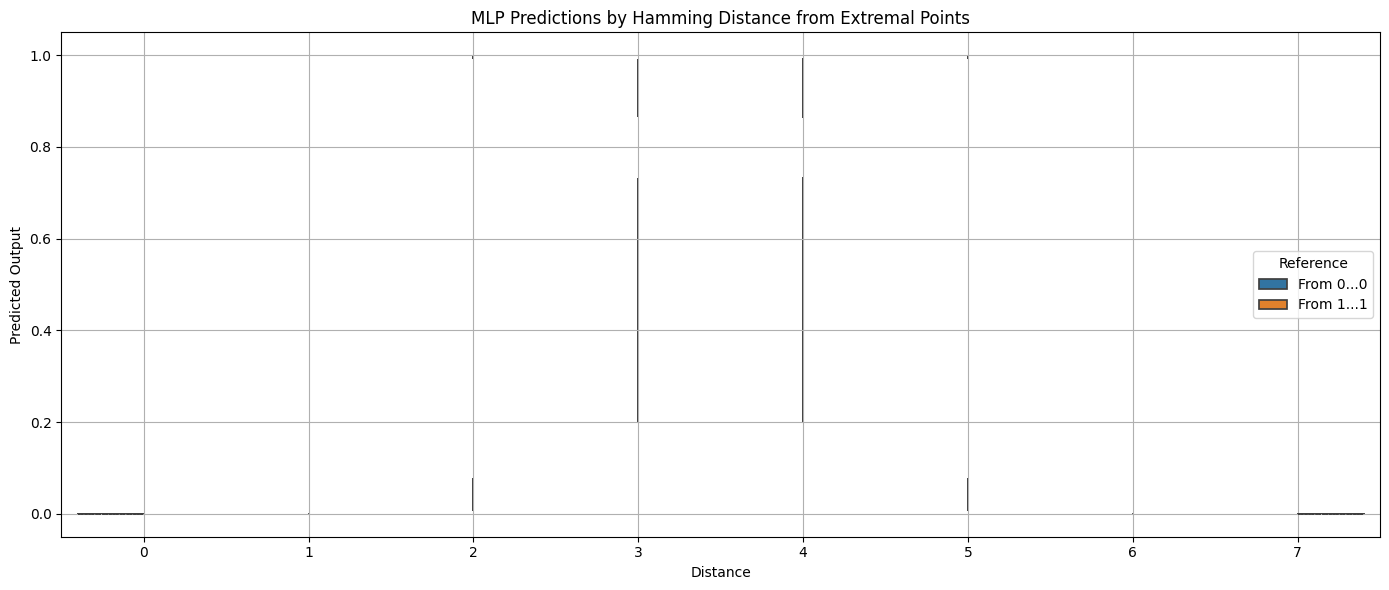

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setup
torch.manual_seed(0)
n_bits = 7
hidden_dim = 64
n_epochs = 1000
lr = 0.01

# Extremal points: 0...0 and 1...1
x_zeros = torch.zeros(n_bits)
x_ones = torch.ones(n_bits)
y_zeros = torch.tensor([x_zeros.sum() % 2], dtype=torch.float32)
y_ones = torch.tensor([x_ones.sum() % 2], dtype=torch.float32)

X_train = torch.stack([x_zeros, x_ones])
y_train = torch.stack([y_zeros, y_ones]).view(-1, 1)

# Simple MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

model = SimpleMLP(n_bits, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

# Train model
for _ in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()

# Sample function
def sample_at_distance(x_ref, dist, n_samples):
    samples = []
    for _ in range(n_samples):
        idx = torch.randperm(n_bits)[:dist]
        x = x_ref.clone()
        x[idx] = 1 - x[idx]
        samples.append(x)
    return torch.stack(samples)

# Collect predictions for violin plot
data = {"Distance": [], "Prediction": [], "Reference": []}
distances = list(range(n_bits + 1))

model.eval()
with torch.no_grad():
    for d in distances:
        s0 = sample_at_distance(x_zeros, d, 100)
        s1 = sample_at_distance(x_ones, d, 100)
        preds0 = model(s0).view(-1)
        preds1 = model(s1).view(-1)

        data["Distance"].extend([d] * 100)
        data["Prediction"].extend(preds0.tolist())
        data["Reference"].extend(["From 0...0"] * 100)

        data["Distance"].extend([d] * 100)
        data["Prediction"].extend(preds1.tolist())
        data["Reference"].extend(["From 1...1"] * 100)

# Plot with seaborn
df = pd.DataFrame(data)
plt.figure(figsize=(14, 6))
sns.violinplot(data=df, x="Distance", y="Prediction", hue="Reference", split=True, inner="quartile")
plt.title("MLP Predictions by Hamming Distance from Extremal Points")
plt.ylabel("Predicted Output")
plt.grid(True)
plt.tight_layout()
plt.show()


In [100]:
# Summarize mean and variance at each distance from each reference
summary_df = pd.DataFrame(data)
stats = summary_df.groupby(["Distance", "Reference"])["Prediction"].agg(["mean", "var"]).reset_index()
print(stats)


    Distance   Reference      mean           var
0          0  From 0...0  0.000056  0.000000e+00
1          0  From 1...1  0.999992  0.000000e+00
2          1  From 0...0  0.001428  1.375364e-07
3          1  From 1...1  0.999852  7.538512e-10
4          2  From 0...0  0.038530  1.535370e-04
5          2  From 1...1  0.997349  5.807913e-07
6          3  From 0...0  0.483859  8.686453e-03
7          3  From 1...1  0.950005  3.265964e-04
8          4  From 0...0  0.949375  4.238915e-04
9          4  From 1...1  0.484762  9.230386e-03
10         5  From 0...0  0.997303  7.466702e-07
11         5  From 1...1  0.037826  1.768470e-04
12         6  From 0...0  0.999849  7.040498e-10
13         6  From 1...1  0.001449  1.508330e-07
14         7  From 0...0  0.999992  0.000000e+00
15         7  From 1...1  0.000056  0.000000e+00


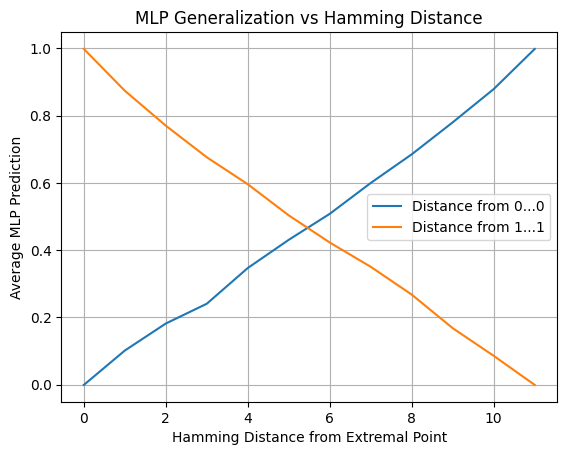

In [175]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Setup
torch.manual_seed(0)
n_bits = 11
hidden_dim = 256
n_epochs = 1000
lr = 0.001

# All-zeros and all-ones inputs
x_zeros = torch.zeros(n_bits)
x_ones = torch.ones(n_bits)
y_zeros = torch.tensor([x_zeros.sum() % 2], dtype=torch.float32)
y_ones = torch.tensor([x_ones.sum() % 2], dtype=torch.float32)

X_train = torch.stack([x_zeros, x_ones])
y_train = torch.stack([y_zeros, y_ones]).view(-1, 1)

# Define simple MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = SimpleMLP(n_bits, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.L1Loss()

# Train
for _ in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()

# Generate samples at specific Hamming distances
def sample_at_distance(x_ref, dist, n_samples):
    samples = []
    for _ in range(n_samples):
        idx = torch.randperm(n_bits)[:dist]
        x = x_ref.clone()
        x[idx] = 1 - x[idx]  # flip bits
        samples.append(x)
    return torch.stack(samples)

# Measure prediction as function of distance
distances = list(range(0, n_bits + 1))
preds_from_zeros = []
preds_from_ones = []

model.eval()
with torch.no_grad():
    for d in distances:
        s0 = sample_at_distance(x_zeros, d, 100)
        s1 = sample_at_distance(x_ones, d, 100)
        preds0 = model(s0).view(-1)
        preds1 = model(s1).view(-1)
        preds_from_zeros.append(preds0.mean().item())
        preds_from_ones.append(preds1.mean().item())

# Plot
plt.plot(distances, preds_from_zeros, label='Distance from 0...0')
plt.plot(distances, preds_from_ones, label='Distance from 1...1')
plt.xlabel('Hamming Distance from Extremal Point')
plt.ylabel('Average MLP Prediction')
plt.title('MLP Generalization vs Hamming Distance')
plt.legend()
plt.grid(True)
plt.show()


In [210]:
import torch
import itertools
import random

n_bits = 11
samples_per_count = 5

# --- TRAINING SET ---
train_X = []
for i in range(samples_per_count):
    for k in range(n_bits + 1):
        bits = [1] * k + [0] * (n_bits - k)
        random.shuffle(bits)
        train_X.append(bits)

train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = train_X.sum(dim=1).int() % 2  # Parity labels

# --- TEST SET ---
all_bitstrings = list(itertools.product([0, 1], repeat=n_bits))
test_X = torch.tensor(all_bitstrings, dtype=torch.float32)
test_y = test_X.sum(dim=1).int() % 2  # Parity labels

# Optionally print sizes
print(f"Training set: {train_X.shape}, Test set: {test_X.shape}")


Training set: torch.Size([60, 11]), Test set: torch.Size([2048, 11])


In [237]:
meta_train_y = test_y.float().view(-1, 1)

In [246]:
meta_train_y

tensor([[0.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [1.]])

In [254]:
meta_train_X = model(test_X).detach() - 0.5

In [255]:
meta_train_X

tensor([[-0.5010],
        [-0.3763],
        [-0.5780],
        ...,
        [ 0.4334],
        [ 0.3370],
        [ 0.4987]])

In [273]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Hyperparameters
loss_threshold = 0.01
max_epochs = 1000
batch_size = 256

# Model and optimizer
# meta_model = SimpleMLP(input_dim=1, hidden_dim=1024)
meta_model = FFNN(input_dim=1, hidden_dim=hidden_dim, output_dim=1, n_layers=2, activation='elu')
meta_optimizer = optim.Adam(meta_model.parameters(), lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss() #nn.L1Loss()

# Dataset and DataLoader
meta_dataset = TensorDataset(meta_train_X, meta_train_y)
meta_loader = DataLoader(meta_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in tqdm(range(max_epochs)):
    meta_model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in meta_loader:
        meta_optimizer.zero_grad()
        out = meta_model(batch_X)
        loss = loss_fn(out, batch_y)
        loss.backward()
        meta_optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= len(meta_dataset)
    print(epoch_loss)
    if epoch_loss < loss_threshold:
        break


  1%|█▏                                                                                      | 13/1000 [00:00<00:15, 64.15it/s]

0.6941362172365189
0.6934032738208771
0.6932625621557236
0.6936039626598358
0.693580649793148
0.6935209259390831
0.6933656707406044
0.6932556852698326
0.6934869289398193
0.6933535560965538
0.6931872293353081
0.6934736222028732
0.693256713449955
0.6932690590620041


  3%|██▍                                                                                     | 28/1000 [00:00<00:14, 68.42it/s]

0.6934192031621933
0.6933105364441872
0.6934937015175819
0.6933240294456482
0.6937256827950478
0.6936337649822235
0.6933972388505936
0.6938912644982338
0.6969086676836014
0.6954852715134621
0.6953801065683365
0.6942445933818817
0.6936275735497475
0.6935988292098045
0.6933592259883881


  4%|███▊                                                                                    | 43/1000 [00:00<00:13, 69.29it/s]

0.6933640390634537
0.6933599039912224
0.6936512589454651
0.6935049965977669
0.6934260278940201
0.6942436248064041
0.6940206214785576
0.6938679367303848
0.6935212761163712
0.6932363361120224
0.6934108063578606
0.6943792626261711
0.6939086019992828
0.6935064569115639
0.6934249848127365


  6%|█████                                                                                   | 57/1000 [00:00<00:14, 66.85it/s]

0.6932280361652374
0.6936197504401207
0.6932434663176537
0.6932387501001358
0.6935045421123505
0.6933516412973404
0.6932814717292786
0.6932467967271805
0.6932702958583832
0.6936298832297325
0.6932109221816063
0.6934244409203529
0.6933168023824692


  7%|██████▎                                                                                 | 72/1000 [00:01<00:13, 69.04it/s]

0.6932667195796967
0.6933141872286797
0.6932161301374435
0.6934623196721077
0.6932641342282295
0.6939796879887581
0.6946623772382736
0.6930734515190125
0.693428710103035
0.693456307053566
0.693670243024826
0.6933445781469345
0.6934314742684364
0.6932409033179283
0.6937026381492615


  8%|██████▉                                                                                 | 79/1000 [00:01<00:13, 67.04it/s]

0.6936151161789894
0.6937053874135017
0.6934807822108269
0.6934075802564621
0.6932771503925323
0.693335235118866
0.6933195441961288
0.6935203075408936
0.6932888627052307
0.6933674141764641
0.6932416930794716
0.6935010999441147
0.6932361647486687


  9%|████████▏                                                                               | 93/1000 [00:01<00:13, 66.56it/s]

0.6933562308549881
0.6939319744706154
0.693239726126194
0.6935929358005524
0.6932053491473198
0.6937152072787285
0.693542830646038
0.6939360350370407
0.6942104697227478
0.6939409747719765
0.6934864819049835
0.6932192444801331
0.6931908130645752
0.6932498216629028
0.6934375613927841


 11%|█████████▍                                                                             | 109/1000 [00:01<00:12, 69.17it/s]

0.6935190036892891
0.693807989358902
0.6935714408755302
0.6940362080931664
0.6934900730848312
0.6934901624917984
0.6935698762536049
0.693151943385601
0.6933272555470467
0.6932354420423508
0.693438246846199
0.6932826489210129
0.6932580098509789
0.6934938356280327
0.693388506770134


 12%|██████████▉                                                                            | 125/1000 [00:01<00:12, 71.59it/s]

0.693170078098774
0.6935438811779022
0.6932453960180283
0.6933424472808838
0.693277008831501
0.6932688131928444
0.6932269632816315
0.6932889968156815
0.6932836621999741
0.6933525875210762
0.6933631226420403
0.6935070157051086
0.6932490393519402
0.6934774965047836
0.6931426748633385


 14%|████████████▎                                                                          | 141/1000 [00:02<00:12, 69.96it/s]

0.6933970972895622
0.6936803311109543
0.6932378634810448
0.6936589404940605
0.693543404340744
0.6932936757802963
0.6933477818965912
0.693321630358696
0.6931552141904831
0.6935498267412186
0.6943247243762016
0.6930923759937286
0.6934190019965172
0.6937042996287346


 16%|█████████████▌                                                                         | 156/1000 [00:02<00:12, 67.52it/s]

0.6934341937303543
0.6933403313159943
0.6933542490005493
0.6933446452021599
0.693710096180439
0.6932330653071404
0.6935584470629692
0.6934710964560509
0.6934032365679741
0.6936031803488731
0.6946208029985428
0.6932094842195511
0.6937705501914024
0.6932427883148193


 17%|██████████████▊                                                                        | 170/1000 [00:02<00:12, 66.56it/s]

0.6933022886514664
0.6935443356633186
0.693048007786274
0.6935487538576126
0.6931751295924187
0.6933493316173553
0.6936646848917007
0.693192608654499
0.6931980773806572
0.6934240385890007
0.6935608759522438
0.6937415823340416
0.6934667900204659
0.6933016404509544


 18%|████████████████                                                                       | 184/1000 [00:02<00:12, 67.01it/s]

0.6934269592165947
0.6933756619691849
0.6938727349042892
0.6937521323561668
0.693995825946331
0.6941661015152931
0.694133423268795
0.6935212910175323
0.6933672353625298
0.6932800263166428
0.6932315304875374
0.6931963264942169
0.6934838593006134
0.6930873468518257


 20%|█████████████████▎                                                                     | 199/1000 [00:02<00:11, 68.18it/s]

0.693565808236599
0.6937169060111046
0.6936955079436302
0.6931804940104485
0.6932504400610924
0.6932330951094627
0.6933890655636787
0.6931841820478439
0.6934540346264839
0.6936496421694756
0.6935657039284706
0.693338967859745
0.6933484524488449
0.6933716908097267


 21%|██████████████████▌                                                                    | 213/1000 [00:03<00:11, 67.60it/s]

0.6933810412883759
0.6933438405394554
0.6932086497545242
0.6932516321539879
0.6932775899767876
0.6935266330838203
0.6935026869177818
0.6939662322402
0.693433865904808
0.6935008242726326
0.6932058334350586
0.6933009028434753
0.6933833137154579
0.693290650844574


 23%|███████████████████▋                                                                   | 227/1000 [00:03<00:11, 68.16it/s]

0.6932843923568726
0.6936752647161484
0.6935568898916245
0.6933218166232109
0.6932101398706436
0.6934327781200409
0.6937682330608368
0.6932512745261192
0.693480983376503
0.6932980120182037
0.6933083832263947
0.6935430020093918
0.6933425441384315
0.6931995525956154


 24%|█████████████████████                                                                  | 242/1000 [00:03<00:10, 69.72it/s]

0.6934233084321022
0.6931610703468323
0.6934684738516808
0.6934125944972038
0.6932602748274803
0.6933954432606697
0.6933422684669495
0.6940576955676079
0.6935635879635811
0.6934112682938576
0.6939226314425468
0.6932003796100616
0.6934648007154465
0.6939767673611641
0.6935456022620201


 26%|██████████████████████▎                                                                | 256/1000 [00:03<00:10, 67.78it/s]

0.6933388710021973
0.6933021247386932
0.6937940567731857
0.6932203769683838
0.693461999297142
0.6931676939129829
0.6934756636619568
0.695241279900074
0.6932139694690704
0.6937434822320938
0.6932487338781357
0.693343348801136
0.6937466189265251
0.6942215636372566


 27%|███████████████████████▍                                                               | 270/1000 [00:03<00:10, 67.86it/s]

0.6932012587785721
0.6935551762580872
0.6935886442661285
0.6932182461023331
0.693310558795929
0.6933553591370583
0.6932577043771744
0.6935485228896141
0.6934773176908493
0.6935228630900383
0.69356569647789
0.693315178155899
0.6937094330787659
0.6935320496559143


 28%|████████████████████████                                                               | 277/1000 [00:04<00:14, 49.67it/s]

0.6936576813459396
0.6933676823973656
0.6934468299150467
0.6935238316655159
0.6932576149702072
0.6932346746325493


 29%|█████████████████████████▎                                                             | 291/1000 [00:04<00:12, 56.42it/s]

0.6937752515077591
0.693230427801609
0.6934134662151337
0.6933274641633034
0.6936722695827484
0.6931177005171776
0.6933352202177048
0.6934216544032097
0.6936981976032257
0.6932321190834045
0.6932924911379814
0.6935051679611206
0.6933623403310776
0.6931742280721664


 30%|██████████████████████████▌                                                            | 305/1000 [00:04<00:11, 58.94it/s]

0.6932483017444611
0.6933914944529533
0.6932824850082397
0.6934274807572365
0.6933708116412163
0.6934537813067436
0.6939901784062386
0.693556472659111
0.6934894025325775
0.6936854869127274
0.6935789957642555
0.6933305785059929
0.6933108493685722
0.6932407021522522


 31%|███████████████████████████▏                                                           | 312/1000 [00:04<00:11, 57.98it/s]

0.6936274990439415
0.6931986957788467
0.6933807879686356
0.6933035328984261
0.6933775022625923
0.6939863711595535
0.6931471824645996
0.6934773623943329
0.693292535841465
0.6936126202344894
0.6940144002437592
0.6934506520628929
0.6934378519654274


 33%|████████████████████████████▌                                                          | 328/1000 [00:04<00:10, 64.98it/s]

0.6934913545846939
0.6933297961950302
0.6933271959424019
0.6933087259531021
0.6931675523519516
0.6932627558708191
0.6937903016805649
0.6930709257721901
0.6936550289392471
0.6937498450279236
0.6936914175748825
0.6932494565844536
0.6936690807342529
0.6940711438655853


 34%|█████████████████████████████▊                                                         | 343/1000 [00:05<00:09, 66.09it/s]

0.6933673843741417
0.6933376863598824
0.6932667940855026
0.6937112137675285
0.6930891573429108
0.693388007581234
0.6933563351631165
0.6940412744879723
0.693372517824173
0.693609431385994
0.6932595372200012
0.6933271512389183
0.6932704672217369
0.6932626515626907
0.6932886838912964


 36%|███████████████████████████████▏                                                       | 359/1000 [00:05<00:09, 69.00it/s]

0.6932802125811577
0.6933304443955421
0.6933625787496567
0.6935417726635933
0.6935821250081062
0.6934254020452499
0.6932427063584328
0.6952391490340233
0.6933792978525162
0.6938840672373772
0.6938029155135155
0.6937861517071724
0.6933629140257835
0.6937667727470398
0.6931162029504776


 37%|████████████████████████████████▍                                                      | 373/1000 [00:05<00:09, 68.42it/s]

0.6938692107796669
0.6935972645878792
0.6935823932290077
0.6934428885579109
0.6935189142823219
0.6936110630631447
0.6929161697626114
0.6933829560875893
0.693386435508728
0.6933737993240356
0.693397231400013
0.6934555768966675
0.6934650242328644
0.6934042125940323
0.6936062201857567


 39%|█████████████████████████████████▊                                                     | 389/1000 [00:05<00:08, 70.44it/s]

0.6935146972537041
0.6934181526303291
0.6931727603077888
0.6941776722669601
0.6934337168931961
0.6932885050773621
0.6934647411108017
0.6932299509644508
0.6935438960790634
0.6935733780264854
0.693369947373867
0.6935678124427795
0.6938464418053627
0.6933256760239601
0.6933412551879883


 40%|███████████████████████████████████▏                                                   | 405/1000 [00:06<00:08, 70.40it/s]

0.6932786554098129
0.6933283433318138
0.6935602352023125
0.6933966651558876
0.6931224688887596
0.6934413090348244
0.6934172362089157
0.6933537498116493
0.6935750097036362
0.6941978931427002
0.693213976919651
0.6935116648674011
0.693444162607193
0.6936525925993919


 41%|███████████████████████████████████▉                                                   | 413/1000 [00:06<00:08, 67.79it/s]

0.6933488622307777
0.6933796256780624
0.6931600943207741
0.6933094784617424
0.6932188868522644
0.6934127807617188
0.6940095275640488
0.6936022266745567
0.6933151856064796
0.6932509765028954
0.6934192031621933
0.6932426616549492
0.693335086107254


 43%|█████████████████████████████████████▏                                                 | 427/1000 [00:06<00:08, 66.55it/s]

0.6932881399989128
0.6933464258909225
0.6937215849757195
0.6934380009770393
0.6932410523295403
0.6933110132813454
0.6939208060503006
0.6937647014856339
0.6932976096868515
0.6932299435138702
0.6933462843298912
0.6934454962611198
0.6933877319097519
0.6932262480258942
0.6935042217373848


 44%|██████████████████████████████████████▍                                                | 442/1000 [00:06<00:08, 68.64it/s]

0.6934337019920349
0.6931610479950905
0.6932466626167297
0.6932896375656128
0.6932952776551247
0.6936760693788528
0.6932367533445358
0.693438932299614
0.6942327320575714
0.6938647627830505
0.6932798996567726
0.6934171169996262
0.6933462768793106
0.6933968886733055
0.6933324113488197


 46%|███████████████████████████████████████▊                                               | 457/1000 [00:06<00:07, 67.95it/s]

0.6936879307031631
0.6940203979611397
0.6936830058693886
0.6936085745692253
0.6932841017842293
0.6932600662112236
0.6934408769011497
0.6933043822646141
0.6932921260595322
0.6934752762317657
0.6932370364665985
0.6932583078742027
0.6932805106043816
0.6933122873306274


 47%|████████████████████████████████████████▉                                              | 471/1000 [00:07<00:07, 66.97it/s]

0.6934317722916603
0.6934890076518059
0.6932985931634903
0.6932418569922447
0.6934715434908867
0.6931656450033188
0.6931988075375557
0.6932414993643761
0.6933920755982399
0.6931874006986618
0.694402888417244
0.6931746825575829
0.6935804858803749
0.6935758516192436
0.6933000534772873


 49%|██████████████████████████████████████████▎                                            | 487/1000 [00:07<00:07, 69.80it/s]

0.6932347863912582
0.6934047341346741
0.6931938827037811
0.6934064254164696
0.6932875141501427
0.6934835240244865
0.6931861340999603
0.6933926120400429
0.693257600069046
0.6932780742645264
0.6939064189791679
0.6932984963059425
0.693337693810463
0.6932142227888107


 50%|███████████████████████████████████████████▌                                           | 501/1000 [00:07<00:07, 68.14it/s]

0.6943257376551628
0.6939395666122437
0.6935793682932854
0.6933868527412415
0.6931442692875862
0.6933764442801476
0.6933286413550377
0.6932632029056549
0.6931801810860634
0.6936372146010399
0.6931264474987984
0.6933902129530907
0.6934402212500572
0.693231076002121


 52%|████████████████████████████████████████████▊                                          | 515/1000 [00:07<00:07, 68.54it/s]

0.6933360770344734
0.6932658180594444
0.6933370977640152
0.6932585164904594
0.6934523358941078
0.6935100331902504
0.6941290199756622
0.6944645196199417
0.6936586871743202
0.6935383677482605
0.6932171210646629
0.6934474110603333
0.693305604159832
0.693415068089962


 53%|██████████████████████████████████████████████                                         | 530/1000 [00:07<00:06, 68.32it/s]

0.6932170763611794
0.6933145448565483
0.693693719804287
0.6933992654085159
0.693304754793644
0.693225622177124
0.6932214573025703
0.6931644603610039
0.6933682411909103
0.6933535784482956
0.693177193403244
0.6933269277215004
0.6931878626346588
0.6932536885142326
0.6932556182146072


 55%|███████████████████████████████████████████████▍                                       | 545/1000 [00:08<00:06, 68.55it/s]

0.693292424082756
0.6934484615921974
0.6937598809599876
0.693415068089962
0.6933256164193153
0.693274699151516
0.6933779194951057
0.6932255402207375
0.6932787448167801
0.6932517811655998
0.6933227479457855
0.693342424929142
0.6932336464524269
0.6932100132107735


 56%|████████████████████████████████████████████████▋                                      | 559/1000 [00:08<00:06, 68.21it/s]

0.6932507902383804
0.6936802566051483
0.6932924836874008
0.6936999782919884
0.6933076307177544
0.6933601126074791
0.693705178797245
0.6937641203403473
0.6932832151651382
0.6934078633785248
0.693693645298481
0.6932319924235344
0.6932427510619164
0.6931975036859512


 57%|█████████████████████████████████████████████████▉                                     | 574/1000 [00:08<00:06, 69.00it/s]

0.6932194977998734
0.6932588443160057
0.6935267075896263
0.6931120008230209
0.6936275735497475
0.6933005452156067
0.6940486654639244
0.6938513070344925
0.6934660375118256
0.6937866136431694
0.6937523558735847
0.6935654953122139
0.6932177171111107
0.6937967240810394


 59%|███████████████████████████████████████████████████▎                                   | 590/1000 [00:08<00:05, 69.86it/s]

0.693446435034275
0.6934157237410545
0.6934943720698357
0.6933571919798851
0.6934928894042969
0.6934664025902748
0.6933587267994881
0.6932736411690712
0.6932620778679848
0.6932540982961655
0.6931988000869751
0.6935619413852692
0.6936107501387596
0.6932419687509537
0.6932993456721306


 60%|████████████████████████████████████████████████████▋                                  | 605/1000 [00:09<00:05, 69.76it/s]

0.693408191204071
0.6932771429419518
0.6935651749372482
0.6930669695138931
0.6933535560965538
0.6935045644640923
0.6933033466339111
0.6933110132813454
0.6932509690523148
0.6935356482863426
0.6931518390774727
0.6937257573008537
0.6938610225915909
0.6936445161700249
0.6935877650976181


 62%|██████████████████████████████████████████████████████                                 | 621/1000 [00:09<00:05, 71.18it/s]

0.6935329809784889
0.6937824785709381
0.6934958025813103
0.6933532953262329
0.6932706981897354
0.6932482048869133
0.6933588534593582
0.6932604759931564
0.6931941509246826
0.6933189556002617
0.6932821497321129
0.694268099963665
0.6936008855700493
0.69368477165699
0.6938560381531715


 64%|███████████████████████████████████████████████████████▍                               | 637/1000 [00:09<00:05, 70.99it/s]

0.6940160021185875
0.6932733654975891
0.6935840919613838
0.6932606473565102
0.6935453414916992
0.693499930202961
0.6933232098817825
0.6932826712727547
0.693290151655674
0.6932632625102997
0.6932819113135338
0.6934135630726814
0.6934207156300545
0.6934638693928719
0.6933493316173553


 64%|████████████████████████████████████████████████████████                               | 645/1000 [00:09<00:04, 71.13it/s]

0.6933099925518036
0.693236880004406
0.6934171915054321
0.6933155283331871
0.6932587325572968
0.6933757960796356
0.6932281106710434
0.6932430118322372


 66%|█████████████████████████████████████████████████████████▍                             | 660/1000 [00:09<00:05, 57.23it/s]

0.6933126002550125
0.6937269195914268
0.6930909156799316
0.6933881714940071
0.6933080330491066
0.6934718787670135
0.6934874877333641
0.6933994516730309
0.6933896690607071
0.6933601126074791
0.6932528540492058
0.6931967958807945
0.6932984814047813
0.6932541951537132
0.6933109611272812


 68%|██████████████████████████████████████████████████████████▋                            | 675/1000 [00:10<00:05, 63.14it/s]

0.6933149844408035
0.693408839404583
0.6932312622666359
0.6932210475206375
0.6935380101203918
0.6932101845741272
0.6933682486414909
0.6934238374233246
0.6932945847511292
0.6933681443333626
0.6932057216763496
0.6936649903655052
0.6937147974967957
0.6936921328306198
0.6933571994304657


 68%|███████████████████████████████████████████████████████████▍                           | 683/1000 [00:10<00:04, 66.24it/s]

0.6931596025824547
0.6932815164327621
0.6934140622615814
0.693409152328968
0.6933402642607689
0.6934807524085045
0.6931564435362816
0.6933029219508171
0.693280428647995
0.6932383552193642
0.6932094171643257
0.6933615803718567
0.6934928223490715
0.6936559453606606
0.6935518458485603


 70%|████████████████████████████████████████████████████████████▊                          | 699/1000 [00:10<00:04, 70.25it/s]

0.6934492439031601
0.6933352649211884
0.6932516545057297
0.6933021321892738
0.6932242438197136
0.6936220750212669
0.6936911344528198
0.6931299269199371
0.6933052614331245
0.6936487555503845
0.6932184100151062
0.6933038309216499
0.6932116374373436
0.6935130208730698
0.6935211643576622


 72%|██████████████████████████████████████████████████████████████▏                        | 715/1000 [00:10<00:04, 70.36it/s]

0.6939936503767967
0.6932437792420387
0.6941075697541237
0.6939535066485405
0.6934781596064568
0.6932737529277802
0.6937988623976707
0.6931573674082756
0.6936530768871307
0.6933743059635162
0.6934254020452499
0.6932118386030197
0.6932638138532639
0.6931565999984741
0.693418338894844


 73%|███████████████████████████████████████████████████████████████▌                       | 731/1000 [00:10<00:03, 72.41it/s]

0.6932961940765381
0.6934964135289192
0.6931773126125336
0.6932010874152184
0.6932823061943054
0.6934419646859169
0.6932378634810448
0.69331044703722
0.6933344006538391
0.6932328268885612
0.6936356797814369
0.693210057914257
0.6933756172657013
0.6934912130236626
0.6930518448352814
0.6932857781648636


 75%|████████████████████████████████████████████████████████████████▉                      | 747/1000 [00:11<00:03, 71.45it/s]

0.6937873810529709
0.6933623999357224
0.6932987421751022
0.6935282796621323
0.6932536959648132
0.6943996176123619
0.6930989548563957
0.6935324743390083
0.6933819428086281
0.6935693398118019
0.6930651143193245
0.693356990814209
0.6935617700219154
0.6931931227445602


 76%|██████████████████████████████████████████████████████████████████▍                    | 763/1000 [00:11<00:03, 68.29it/s]

0.6935521811246872
0.6934182569384575
0.6934551298618317
0.6932429596781731
0.6932583674788475
0.693172313272953
0.6932908147573471
0.6934167668223381
0.693195104598999
0.6934730708599091
0.6933030933141708
0.6932763159275055
0.6932734623551369
0.6932744532823563


 78%|███████████████████████████████████████████████████████████████████▋                   | 778/1000 [00:11<00:03, 70.52it/s]

0.6934125423431396
0.6933432593941689
0.6932473480701447
0.6933310180902481
0.693272091448307
0.6933440938591957
0.6931197494268417
0.6936150044202805
0.6937774270772934
0.6933592855930328
0.6935447081923485
0.6934303268790245
0.6936501488089561
0.6932591497898102
0.69325340539217


 79%|█████████████████████████████████████████████████████████████████████                  | 794/1000 [00:11<00:02, 71.56it/s]

0.693280391395092
0.6932694464921951
0.6935228481888771
0.6933834478259087
0.6936099603772163
0.693479873239994
0.693346232175827
0.6933870017528534
0.6932387724518776
0.6932385638356209
0.693409688770771
0.693288154900074
0.6931666731834412
0.6932205110788345
0.6933429911732674


 80%|█████████████████████████████████████████████████████████████████████▊                 | 802/1000 [00:11<00:02, 69.99it/s]

0.6932806298136711
0.6932618841528893
0.6932166442275047
0.6931951195001602
0.6939361020922661
0.6934260204434395
0.69343551248312
0.693992406129837
0.6935124918818474
0.6938207000494003
0.6939221173524857
0.6932788714766502
0.6935303583741188
0.6933266669511795


 82%|███████████████████████████████████████████████████████████████████████                | 817/1000 [00:12<00:02, 67.78it/s]

0.6930569484829903
0.6933843716979027
0.6932544186711311
0.6939751952886581
0.693956546485424
0.6935437470674515
0.6933455541729927
0.6935870125889778
0.6932696625590324
0.6934941112995148
0.6939986497163773
0.6931059509515762
0.6933403685688972
0.6934460625052452
0.6932160407304764


 83%|████████████████████████████████████████████████████████████████████████▍              | 832/1000 [00:12<00:02, 69.76it/s]

0.6932218074798584
0.6932901442050934
0.693427674472332
0.6931864023208618
0.6932083889842033
0.693406954407692
0.6931411251425743
0.6932562664151192
0.6932436302304268
0.6935227736830711
0.6935573443770409
0.693457119166851
0.6933647841215134
0.6932769864797592


 85%|█████████████████████████████████████████████████████████████████████████▌             | 846/1000 [00:12<00:02, 68.16it/s]

0.6935218572616577
0.6933058202266693
0.6933146044611931
0.6932607218623161
0.6932352110743523
0.6935475766658783
0.693191722035408
0.6932404637336731
0.6932811811566353
0.6933760344982147
0.6932386085391045
0.6933278441429138
0.6932545751333237
0.6936582028865814


 86%|██████████████████████████████████████████████████████████████████████████▊            | 860/1000 [00:12<00:02, 67.57it/s]

0.6929793134331703
0.6934405267238617
0.6935501843690872
0.6932710483670235
0.6934259459376335
0.6932803094387054
0.6932030022144318
0.693596363067627
0.6934020295739174
0.6932873949408531
0.6933261454105377
0.6933196932077408
0.6934680938720703
0.6933324486017227


 87%|████████████████████████████████████████████████████████████████████████████           | 874/1000 [00:12<00:01, 65.80it/s]

0.693545512855053
0.6932483240962029
0.6935522258281708
0.6934807822108269
0.693272203207016
0.693202443420887
0.693912461400032
0.6932951509952545
0.6933079287409782
0.6931533738970757
0.69322919100523
0.6934032738208771
0.6931356564164162
0.6933491304516792


 89%|█████████████████████████████████████████████████████████████████████████████▎         | 888/1000 [00:13<00:01, 65.25it/s]

0.6939168199896812
0.6932085156440735
0.6933471262454987
0.6932476162910461
0.6933815255761147
0.693388320505619
0.6931740939617157
0.6933250427246094
0.693163238465786
0.6932047381997108
0.6932260543107986
0.6941462978720665
0.693089447915554
0.693386621773243


 90%|██████████████████████████████████████████████████████████████████████████████▍        | 902/1000 [00:13<00:01, 64.92it/s]

0.6939282715320587
0.6935013607144356
0.6933719888329506
0.693141408264637
0.6933867037296295
0.6933629810810089
0.6934661567211151
0.6932100430130959
0.6932374984025955
0.6934031620621681
0.6932445168495178
0.6932811364531517
0.6938526928424835


 92%|███████████████████████████████████████████████████████████████████████████████▋       | 916/1000 [00:13<00:01, 66.30it/s]

0.6932013556361198
0.693311907351017
0.6932745948433876
0.6933146640658379
0.6933601498603821
0.6933015063405037
0.6934692189097404
0.6942714229226112
0.6940984427928925
0.6934195309877396
0.6933107599616051
0.6932511106133461
0.6933432370424271
0.6932829990983009
0.6932272762060165


 93%|████████████████████████████████████████████████████████████████████████████████▉      | 931/1000 [00:13<00:01, 67.52it/s]

0.6932323426008224
0.6932765543460846
0.6932767108082771
0.6932650879025459
0.6932485178112984
0.6932100132107735
0.69326451420784
0.693205751478672
0.6932087168097496
0.6932893767952919
0.6937235742807388
0.6937448382377625
0.6935169026255608
0.6932103261351585


 94%|██████████████████████████████████████████████████████████████████████████████████▏    | 945/1000 [00:14<00:00, 64.94it/s]

0.6933529451489449
0.6932245641946793
0.6935220882296562
0.6939121410250664
0.6933652684092522
0.6934341564774513
0.6931466683745384
0.6934604197740555
0.6932501047849655
0.693367175757885
0.6932926550507545
0.6933098137378693
0.6933502703905106
0.6934647634625435


 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 961/1000 [00:14<00:00, 68.92it/s]

0.6935364902019501
0.6931681707501411
0.6933063939213753
0.6933393850922585
0.6932475417852402
0.6933203861117363
0.6932986751198769
0.6934726312756538
0.6936563476920128
0.6936971992254257
0.6934452950954437
0.6932660713791847
0.6933787763118744
0.6934953927993774
0.6932740658521652


 98%|████████████████████████████████████████████████████████████████████████████████████▉  | 976/1000 [00:14<00:00, 67.47it/s]

0.6932401359081268
0.693330816924572
0.6932233422994614
0.6934423074126244
0.6935979425907135
0.6932734698057175
0.6933368742465973
0.6932798102498055
0.6933858320116997
0.6932334750890732
0.6932819336652756
0.6933295801281929
0.6933320090174675
0.6933163329958916


 99%|██████████████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:14<00:00, 65.11it/s]

0.693377748131752
0.6932670548558235
0.6932195350527763
0.693234920501709
0.6931968629360199
0.6933430507779121
0.6932873725891113
0.6934210583567619
0.6931944712996483
0.6933452114462852
0.6934648528695107
0.6932151317596436
0.6932636573910713


100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.23it/s]

0.6937366351485252
0.693549707531929
0.6933828890323639
0.6930952072143555
0.693299688398838
0.6933469027280807
0.6932228803634644
0.6932919695973396
0.693544439971447


In [248]:
loss.item()

0.4999999701976776

In [244]:
meta_train_X

tensor([[-0.0010],
        [ 0.1237],
        [-0.0780],
        ...,
        [ 0.9334],
        [ 0.8370],
        [ 0.9987]])

In [140]:
train_y

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=torch.int32)

In [143]:
meta_model

SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [249]:
with torch.no_grad():
    meta_test_X = model(test_X).detach()
    pred_probs = meta_model(meta_test_X).squeeze()
    pred_labels = (pred_probs > 0.5).float()
    accuracy = (pred_labels == test_y).float().mean().item()
print(accuracy)

0.5


In [202]:
pred_probs

tensor([-3.8227e-04,  9.7193e-01,  2.4322e-03,  ...,  5.8750e-01,
         2.7036e-03,  1.0001e+00])

In [161]:
clean_pred_labels = pred_labels.squeeze().int()

In [157]:
test_y

tensor([0, 1, 1,  ..., 0, 0, 1], dtype=torch.int32)

In [166]:
(clean_pred_labels == test_y).float().mean()

tensor(0.5029)

In [167]:
(clean_pred_labels == test_y).sum()

tensor(1030)

In [174]:
train_X

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

0.5


/var/folders/l5/bnxhb0d55rg_wsbyxwcclhfr0000gq/T/ipykernel_89097/4240671357.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="HammingWeight", y="Prediction", inner="quartile", scale="width")


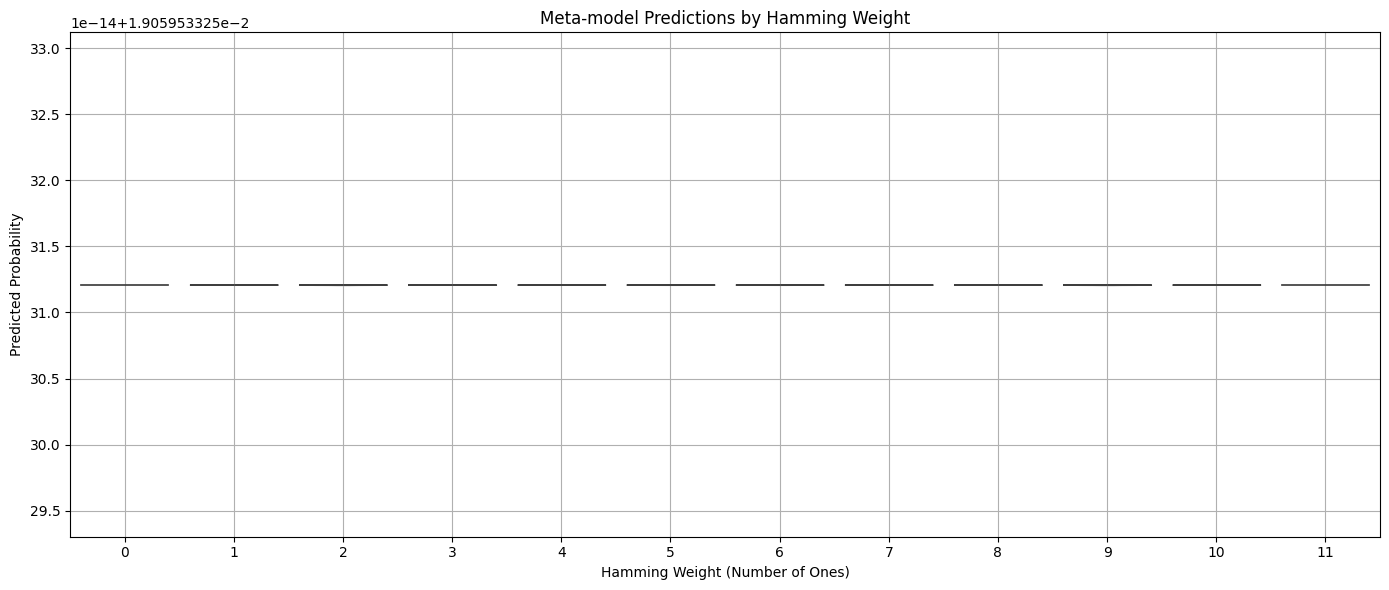

In [250]:
with torch.no_grad():
    meta_test_X = model(test_X).detach()
    pred_probs = meta_model(meta_test_X).squeeze()
    pred_labels = (pred_probs > 0.5).float()
    accuracy = (pred_labels == test_y).float().mean().item()
print(accuracy)

# Compute Hamming weight for each test input
hamming_weights = test_X.sum(dim=1).int()

# Create DataFrame for plotting
df = pd.DataFrame({
    "HammingWeight": hamming_weights.numpy(),
    "Prediction": pred_probs.numpy()
})

# Plot violin plots of predictions grouped by Hamming weight
plt.figure(figsize=(14, 6))
sns.violinplot(data=df, x="HammingWeight", y="Prediction", inner="quartile", scale="width")
plt.title("Meta-model Predictions by Hamming Weight")
plt.xlabel("Hamming Weight (Number of Ones)")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

In [219]:
with torch.no_grad():
    base_pred_probs = model(test_X).detach().squeeze()
    base_pred_labels = (pred_probs > 0.5).float()
    base_accuracy = (base_pred_labels == test_y).float().mean().item()
print(accuracy)

0.501953125


In [220]:
base_pred_probs

tensor([-0.0010,  0.1237, -0.0780,  ...,  0.9334,  0.8370,  0.9987])

/var/folders/l5/bnxhb0d55rg_wsbyxwcclhfr0000gq/T/ipykernel_89097/3366517904.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="HammingWeight", y="Prediction", inner="quartile", scale="width")


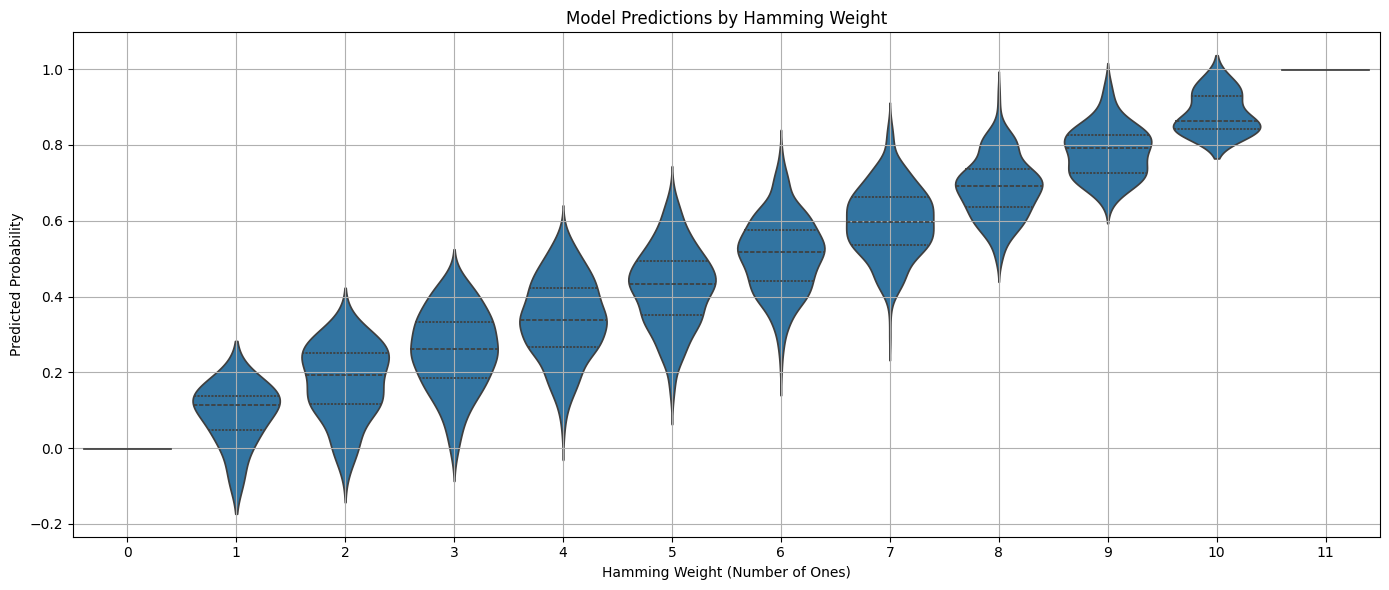

In [259]:
# Compute Hamming weight for each test input
hamming_weights = test_X.sum(dim=1).int()

# Create DataFrame for plotting
df = pd.DataFrame({
    "HammingWeight": hamming_weights.numpy(),
    "Prediction": base_pred_probs.numpy()
})

# Plot violin plots of predictions grouped by Hamming weight
plt.figure(figsize=(14, 6))
sns.violinplot(data=df, x="HammingWeight", y="Prediction", inner="quartile", scale="width")
plt.title("Model Predictions by Hamming Weight")
plt.xlabel("Hamming Weight (Number of Ones)")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Maybe need a few more examples to learn the window.

Epoch 0: loss = 0.6906, acc = 0.5280
Epoch 100: loss = 0.6762, acc = 0.6060
Epoch 200: loss = 0.6605, acc = 0.6240
Epoch 300: loss = 0.6414, acc = 0.6140
Epoch 400: loss = 0.6179, acc = 0.6990
Epoch 500: loss = 0.6032, acc = 0.7010
Epoch 600: loss = 0.5951, acc = 0.7080
Epoch 700: loss = 0.5952, acc = 0.6960
Epoch 800: loss = 0.5910, acc = 0.7060
Epoch 900: loss = 0.5906, acc = 0.7020
Epoch 1000: loss = 0.5892, acc = 0.7170
Epoch 1100: loss = 0.5873, acc = 0.7030
Epoch 1200: loss = 0.5869, acc = 0.7070
Epoch 1300: loss = 0.5900, acc = 0.7140
Epoch 1400: loss = 0.5867, acc = 0.7150
Epoch 1500: loss = 0.5856, acc = 0.7100
Epoch 1600: loss = 0.5898, acc = 0.7130
Epoch 1700: loss = 0.5854, acc = 0.7100
Epoch 1800: loss = 0.5854, acc = 0.7110
Epoch 1900: loss = 0.5868, acc = 0.7080
Epoch 2000: loss = 0.5857, acc = 0.7080
Epoch 2100: loss = 0.5865, acc = 0.7100
Epoch 2200: loss = 0.5852, acc = 0.7080
Epoch 2300: loss = 0.5862, acc = 0.7080
Epoch 2400: loss = 0.5853, acc = 0.7120
Epoch 2500: 

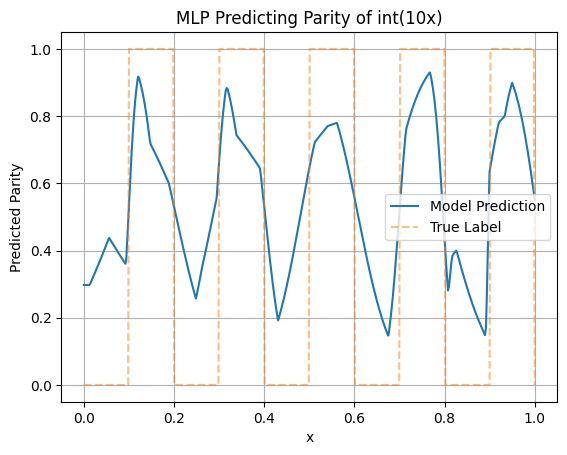

In [276]:
# Test to check whether NN can learn this even if it's perfect

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate dataset
N = 1000
X = torch.rand(N, 1)  # Uniform in [0, 1)
y = ((10 * X).int() % 2).float()  # 0 if even, 1 if odd
y = y.view(-1, 1)
epsilon = 0.3  # 10% label noise
noise = torch.bernoulli(torch.full_like(y, epsilon))
y = (y + noise) % 2  # XOR-like flipping

# Define model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Train
for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    preds = model(X)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        acc = ((preds > 0.5).float() == y).float().mean().item()
        print(f"Epoch {epoch}: loss = {loss.item():.4f}, acc = {acc:.4f}")

# Plot predictions
with torch.no_grad():
    x_plot = torch.linspace(0, 1, 500).view(-1, 1)
    y_true = ((10 * x_plot).int() % 2).float()
    y_pred = model(x_plot)

plt.plot(x_plot.numpy(), y_pred.numpy(), label='Model Prediction')
plt.plot(x_plot.numpy(), y_true.numpy(), label='True Label', alpha=0.5, linestyle='--')
plt.xlabel("x")
plt.ylabel("Predicted Parity")
plt.legend()
plt.title("MLP Predicting Parity of int(10x)")
plt.grid(True)
plt.show()


In [277]:
# Confirmed! But it is much easier with BCE Loss apparently
# It even learns a good classification boundary w/ 30% noise

Epoch 0: loss = 0.4777, acc = 0.5270
Epoch 100: loss = 0.4730, acc = 0.5270
Epoch 200: loss = 0.4701, acc = 0.5270
Epoch 300: loss = 0.4478, acc = 0.5910
Epoch 400: loss = 0.4361, acc = 0.5880
Epoch 500: loss = 0.4307, acc = 0.5820
Epoch 600: loss = 0.4282, acc = 0.5780
Epoch 700: loss = 0.4303, acc = 0.5700
Epoch 800: loss = 0.4296, acc = 0.5790
Epoch 900: loss = 0.4280, acc = 0.5760
Epoch 1000: loss = 0.4285, acc = 0.5690
Epoch 1100: loss = 0.4252, acc = 0.5770
Epoch 1200: loss = 0.4277, acc = 0.5680
Epoch 1300: loss = 0.4250, acc = 0.5730
Epoch 1400: loss = 0.4234, acc = 0.5790
Epoch 1500: loss = 0.4236, acc = 0.5760
Epoch 1600: loss = 0.4260, acc = 0.5850
Epoch 1700: loss = 0.4267, acc = 0.5790
Epoch 1800: loss = 0.4220, acc = 0.5770
Epoch 1900: loss = 0.4233, acc = 0.5800
Epoch 2000: loss = 0.4195, acc = 0.6080
Epoch 2100: loss = 0.4130, acc = 0.6040
Epoch 2200: loss = 0.4102, acc = 0.6060
Epoch 2300: loss = 0.4106, acc = 0.6060
Epoch 2400: loss = 0.4091, acc = 0.5990
Epoch 2500: 

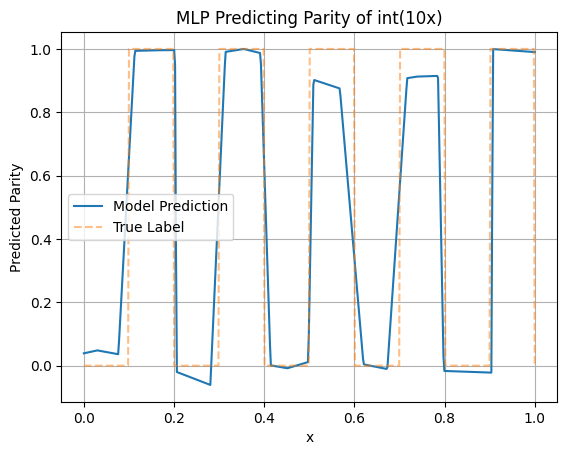

In [278]:
# Test to check whether NN can learn this even if it's perfect

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate dataset
N = 1000
X = torch.rand(N, 1)  # Uniform in [0, 1)
y = ((10 * X).int() % 2).float()  # 0 if even, 1 if odd
y = y.view(-1, 1)
epsilon = 0.3  # 10% label noise
noise = torch.bernoulli(torch.full_like(y, epsilon))
y = (y + noise) % 2  # XOR-like flipping

# Define model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            #nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.L1Loss() #nn.BCELoss()

# Train
for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    preds = model(X)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        acc = ((preds > 0.5).float() == y).float().mean().item()
        print(f"Epoch {epoch}: loss = {loss.item():.4f}, acc = {acc:.4f}")

# Plot predictions
with torch.no_grad():
    x_plot = torch.linspace(0, 1, 500).view(-1, 1)
    y_true = ((10 * x_plot).int() % 2).float()
    y_pred = model(x_plot)

plt.plot(x_plot.numpy(), y_pred.numpy(), label='Model Prediction')
plt.plot(x_plot.numpy(), y_true.numpy(), label='True Label', alpha=0.5, linestyle='--')
plt.xlabel("x")
plt.ylabel("Predicted Parity")
plt.legend()
plt.title("MLP Predicting Parity of int(10x)")
plt.grid(True)
plt.show()


In [279]:
# Perhaps surprisingly, the boundary w/ L1 is better than BCE under high noise

In [283]:
import torch
from torch.autograd import grad

n_bits = 11
m = 100  # number of hidden units
torch.manual_seed(0)

# Inputs
x0 = torch.zeros(n_bits)
x1 = torch.ones(n_bits)
train_X = [x0, x1]
train_y = torch.tensor([[0.0], [1.0]])

def make_k_ones_vector(k):
    x = torch.zeros(n_bits)
    x[:k] = 1
    return x[torch.randperm(n_bits)]

# Initialize NTK model
w = torch.randn(m, n_bits, requires_grad=True)
a = torch.randn(m, requires_grad=True)

def f(x):
    z = torch.relu(w @ x)
    return (a * z).sum()

def get_grad(x):
    y = f(x)
    grads = grad(y, (w, a), retain_graph=True)
    return torch.cat([grads[0].reshape(-1), grads[1]])

# Build kernel matrix
G = [get_grad(x) for x in train_X]
K = torch.tensor([[torch.dot(G[i], G[j]) for j in range(2)] for i in range(2)])
alpha = torch.pinverse(K) @ train_y

# Predict for all k-ones inputs
print("k\tPredicted")
for k in range(n_bits + 1):
    xk = make_k_ones_vector(k)
    Gk = get_grad(xk)
    k_vec = torch.tensor([[torch.dot(Gk, G[0]), torch.dot(Gk, G[1])]])
    y_pred = k_vec @ alpha
    print(f"{k}\t{y_pred.item():.4f}")


k	Predicted
0	0.0000
1	0.1168
2	0.1540
3	0.2207
4	0.3932
5	0.4154
6	0.5426
7	0.6236
8	0.7048
9	0.7994
10	0.8500
11	1.0000


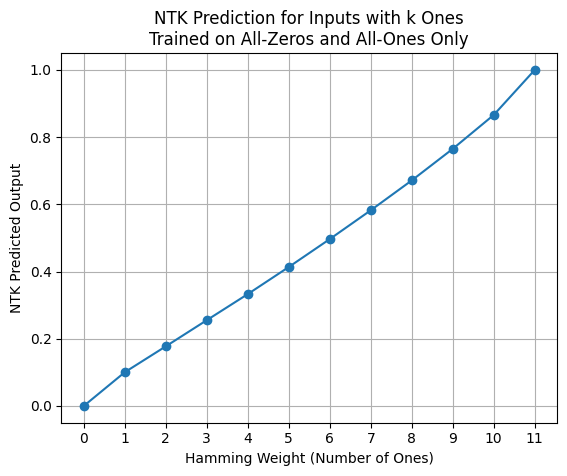

In [291]:
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt

# Config
n_bits = 11
m = 1000000
torch.manual_seed(0)

# Create all-zero and all-one training examples
x0 = torch.zeros(n_bits)
x1 = torch.ones(n_bits)
train_X = [x0, x1]
train_y = torch.tensor([[0.0], [1.0]])

# Initialize parameters for NTK model
w = torch.randn(m, n_bits, requires_grad=True)
a = torch.randn(m, requires_grad=True)

# Network and gradient
def f(x):
    z = torch.relu(w @ x)
    return (a * z).sum()

def get_grad(x):
    y = f(x)
    grads = grad(y, (w, a), retain_graph=True)
    return torch.cat([grads[0].reshape(-1), grads[1]])

# Build NTK matrix
G = [get_grad(x) for x in train_X]
K = torch.tensor([[torch.dot(G[i], G[j]) for j in range(2)] for i in range(2)])
alpha = torch.pinverse(K) @ train_y

# Predict for test inputs with k ones (k = 0..n)
ks = list(range(n_bits + 1))
preds = []
for k in ks:
    xk = torch.zeros(n_bits)
    xk[:k] = 1
    xk = xk[torch.randperm(n_bits)]
    Gk = get_grad(xk)
    k_vec = torch.tensor([[torch.dot(Gk, G[0]), torch.dot(Gk, G[1])]])
    y_pred = k_vec @ alpha
    preds.append(y_pred.item())

# Plot
plt.plot(ks, preds, marker='o')
plt.xticks(ks)
plt.xlabel("Hamming Weight (Number of Ones)")
plt.ylabel("NTK Predicted Output")
plt.title("NTK Prediction for Inputs with k Ones\nTrained on All-Zeros and All-Ones Only")
plt.grid(True)
plt.show()


In [292]:
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt

n_bits = 11
m = 100
torch.manual_seed(0)

# First NTK: trained on 0...0 → 0 and 1...1 → 1
x0 = torch.zeros(n_bits)
x1 = torch.ones(n_bits)
train_X = [x0, x1]
train_y = torch.tensor([[0.0], [1.0]])

w1 = torch.randn(m, n_bits, requires_grad=True)
a1 = torch.randn(m, requires_grad=True)

def f1(x): return (a1 * torch.relu(w1 @ x)).sum()
def grad1(x): return torch.cat(grad(f1(x), (w1, a1), retain_graph=True))

G = [grad1(x) for x in train_X]
K = torch.tensor([[torch.dot(G[i], G[j]) for j in range(2)] for i in range(2)])
alpha = torch.pinverse(K) @ train_y

# Generate predictions and build meta-dataset
meta_X, meta_y, preds = [], [], []
for k in range(n_bits + 1):
    xk = torch.zeros(n_bits)
    xk[:k] = 1
    xk = xk[torch.randperm(n_bits)]
    Gk = grad1(xk)
    kvec = torch.tensor([[torch.dot(Gk, G[0]), torch.dot(Gk, G[1])]])
    pred = (kvec @ alpha).item()
    preds.append(pred)
    meta_X.append([pred])       # meta input is first model's prediction
    meta_y.append([k % 2])      # true parity

meta_X = torch.tensor(meta_X, dtype=torch.float32)
meta_y = torch.tensor(meta_y, dtype=torch.float32)

# Second NTK: learns parity from first NTK’s predictions
w2 = torch.randn(m, 1, requires_grad=True)
a2 = torch.randn(m, requires_grad=True)

def f2(x): return (a2 * torch.relu(w2 @ x)).sum()
def grad2(x): return torch.cat(grad(f2(x), (w2, a2), retain_graph=True))

G2 = [grad2(x) for x in meta_X]
K2 = torch.tensor([[torch.dot(G2[i], G2[j]) for j in range(len(G2))] for i in range(len(G2))])
alpha2 = torch.pinverse(K2) @ meta_y

# Predict with second NTK
meta_preds = []
for gx in G2:
    kvec = torch.tensor([[torch.dot(gx, gj) for gj in G2]])
    meta_preds.append((kvec @ alpha2).item())

# Plot everything
ks = list(range(n_bits + 1))
plt.plot(ks, preds, marker='o', label='First NTK Predictions (confidence)')
plt.plot(ks, meta_preds, marker='x', label='Second NTK Predictions (meta)')
plt.plot(ks, [k % 2 for k in ks], linestyle='--', label='True Parity')
plt.xlabel("Hamming Weight (k)")
plt.ylabel("Output")
plt.title("Stacked NTK: Recovering Parity from First NTK's Output")
plt.legend()
plt.grid(True)
plt.show()


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

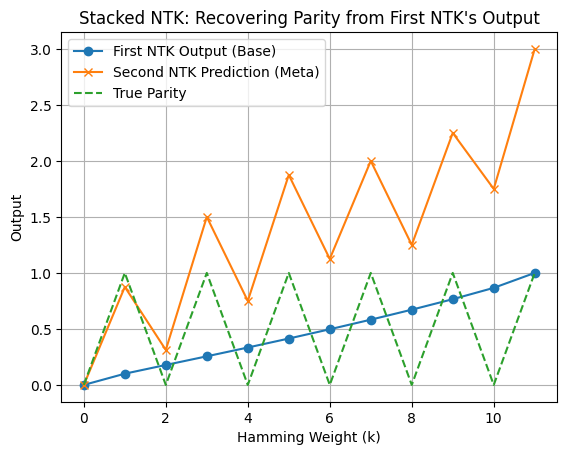

In [299]:
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt

# Configuration
n_bits = 11
m = 40000000
torch.manual_seed(0)

# Training inputs: all-zeros and all-ones
x0 = torch.zeros(n_bits)
x1 = torch.ones(n_bits)
train_X = [x0, x1]
train_y = torch.tensor([[0.0], [1.0]])

# First NTK parameters
w1 = torch.randn(m, n_bits, requires_grad=True)
a1 = torch.randn(m, requires_grad=True)

def f1(x):
    return (a1 * torch.relu(w1 @ x)).sum()

def grad1(x):
    y = f1(x)
    grads = grad(y, (w1, a1), retain_graph=True)
    return torch.cat([grads[0].reshape(-1), grads[1].reshape(-1)])

# Compute NTK kernel matrix and alpha for first NTK
G = [grad1(x) for x in train_X]
K = torch.tensor([[torch.dot(G[i], G[j]) for j in range(2)] for i in range(2)])
alpha = torch.pinverse(K) @ train_y

# Generate meta-training data: (first model prediction, true parity)
ks = list(range(n_bits + 1))
meta_X, meta_y, preds = [], [], []

for k in ks:
    xk = torch.zeros(n_bits)
    xk[:k] = 1
    xk = xk[torch.randperm(n_bits)]
    Gk = grad1(xk)
    kvec = torch.tensor([[torch.dot(Gk, G[0]), torch.dot(Gk, G[1])]])
    pred = (kvec @ alpha).item()
    preds.append(pred)
    meta_X.append([pred])
    meta_y.append([k % 2])

meta_X = torch.tensor(meta_X, dtype=torch.float32)
meta_y = torch.tensor(meta_y, dtype=torch.float32)

# Second NTK parameters
w2 = torch.randn(m, 1, requires_grad=True)
a2 = torch.randn(m, requires_grad=True)

def f2(x):
    return (a2 * torch.relu(w2 @ x)).sum()

def grad2(x):
    y = f2(x)
    grads = grad(y, (w2, a2), retain_graph=True)
    return torch.cat([grads[0].reshape(-1), grads[1].reshape(-1)])

# Compute NTK matrix and alpha for second NTK
G2 = [grad2(x) for x in meta_X]
K2 = torch.tensor([[torch.dot(G2[i], G2[j]) for j in range(len(G2))] for i in range(len(G2))])
alpha2 = torch.pinverse(K2) @ meta_y

# Predict with second NTK
meta_preds = []
for gx in G2:
    kvec = torch.tensor([[torch.dot(gx, gj) for gj in G2]])
    meta_preds.append((kvec @ alpha2).item())

# Plot both first-stage and second-stage predictions
plt.plot(ks, preds, marker='o', label='First NTK Output (Base)')
plt.plot(ks, meta_preds, marker='x', linestyle='-', label='Second NTK Prediction (Meta)')
plt.plot(ks, [k % 2 for k in ks], linestyle='--', label='True Parity')
plt.xlabel("Hamming Weight (k)")
plt.ylabel("Output")
plt.title("Stacked NTK: Recovering Parity from First NTK's Output")
plt.legend()
plt.grid(True)
plt.show()


In [303]:
# Re-run stacked NTK experiment with He initialization after environment reset

import torch
from torch.autograd import grad
import matplotlib.pyplot as plt

# Configuration
n_bits = 11
m = 1000
torch.manual_seed(0)

# Training inputs: all-zeros and all-ones
x0 = torch.zeros(n_bits)
x1 = torch.ones(n_bits)
train_X = [x0, x1]
train_y = torch.tensor([[0.0], [1.0]])

# He initialization for NTK model 1
w1_std = (2 / n_bits) ** 0.5
w1 = torch.randn(m, n_bits) * w1_std
w1.requires_grad_()
a1 = torch.randn(m)
a1.requires_grad_()

def f1(x):
    return (a1 * torch.relu(w1 @ x)).sum()

def grad1(x):
    y = f1(x)
    grads = grad(y, (w1, a1), retain_graph=True)
    return torch.cat([grads[0].reshape(-1), grads[1].reshape(-1)])

# Compute NTK kernel matrix and alpha for first NTK
G = [grad1(x) for x in train_X]
K = torch.tensor([[torch.dot(G[i], G[j]) for j in range(2)] for i in range(2)])
alpha = torch.pinverse(K) @ train_y

# Generate meta-training data: (first model prediction, true parity)
ks = list(range(n_bits + 1))
meta_X, meta_y, preds = [], [], []

for k in ks:
    xk = torch.zeros(n_bits)
    xk[:k] = 1
    xk = xk[torch.randperm(n_bits)]
    Gk = grad1(xk)
    kvec = torch.tensor([[torch.dot(Gk, G[0]), torch.dot(Gk, G[1])]])
    pred = (kvec @ alpha).item()
    preds.append(pred)
    meta_X.append([pred])
    meta_y.append([k % 2])

meta_X = torch.tensor(meta_X, dtype=torch.float32)
meta_y = torch.tensor(meta_y, dtype=torch.float32)

# He initialization for NTK model 2
w2_std = (2 / 1) ** 0.5
w2 = torch.randn(m, 1) * w2_std
w2.requires_grad_()
a2 = torch.randn(m)
a2.requires_grad_()

def f2(x):
    return (a2 * torch.relu(w2 @ x)).sum()

def grad2(x):
    y = f2(x)
    grads = grad(y, (w2, a2), retain_graph=True)
    return torch.cat([grads[0].reshape(-1), grads[1].reshape(-1)])

# Compute NTK matrix and alpha for second NTK
G2 = [grad2(x) for x in meta_X]
K2 = torch.tensor([[torch.dot(G2[i], G2[j]) for j in range(len(G2))] for i in range(len(G2))])
#alpha2 = torch.pinverse(K2) @ meta_y
alpha2 = torch.linalg.solve(K2, meta_y)


# Predict with second NTK
meta_preds = []
for gx in G2:
    kvec = torch.tensor([[torch.dot(gx, gj) for gj in G2]])
    meta_preds.append((kvec @ alpha2).item())

# Plot both first-stage and second-stage predictions
plt.plot(ks, preds, marker='o', label='First NTK Output (Confidence)')
plt.plot(ks, meta_preds, marker='x', linestyle='-', label='Second NTK Prediction (Meta)')
plt.plot(ks, [k % 2 for k in ks], linestyle='--', label='True Parity')
plt.xlabel("Hamming Weight (k)")
plt.ylabel("Output")
plt.title("Stacked NTK with He Initialization")
plt.legend()
plt.grid(True)
plt.show()


_LinAlgError: torch.linalg.solve: The solver failed because the input matrix is singular.

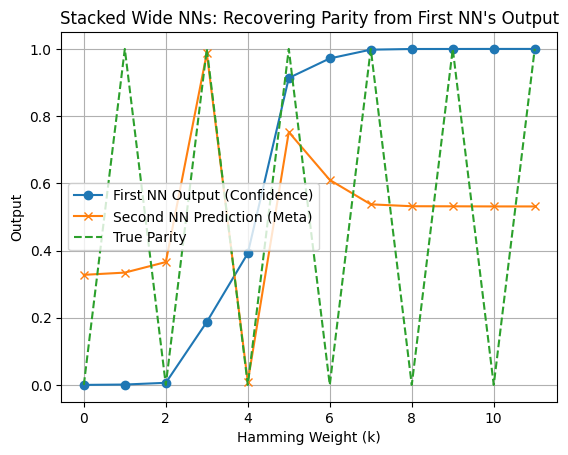

In [307]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Configuration
n_bits = 11
hidden_units = 100
torch.manual_seed(0)

# Training inputs: all-zeros and all-ones
x0 = torch.zeros(n_bits)
x1 = torch.ones(n_bits)
train_X = torch.stack([x0, x1])
train_y = torch.tensor([[0.0], [1.0]])

# First model: 1-hidden-layer NN with ReLU and large width
class WideReLU(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model1 = WideReLU(n_bits, hidden_units)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# Train first model
for _ in range(1000):
    preds = model1(train_X)
    loss = loss_fn(preds, train_y)
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()

# Collect predictions from model1 for all k-ones inputs
ks = list(range(n_bits + 1))
meta_X, meta_y, preds = [], [], []

for k in ks:
    xk = torch.zeros(n_bits)
    xk[:k] = 1
    xk = xk[torch.randperm(n_bits)]
    pred = model1(xk.unsqueeze(0)).item()
    preds.append(pred)
    meta_X.append([pred])
    meta_y.append([k % 2])

meta_X = torch.tensor(meta_X, dtype=torch.float32)
meta_y = torch.tensor(meta_y, dtype=torch.float32)

# Second model: 1-hidden-layer NN with large width
model2 = WideReLU(1, hidden_units)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
loss_fn2 = nn.BCELoss()

# Train second model
for _ in range(1000):
    preds2 = model2(meta_X)
    loss2 = loss_fn2(preds2, meta_y.view(-1, 1))
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

# Predict with second model
meta_preds = model2(meta_X).view(-1).tolist()

# Plot predictions
plt.plot(ks, preds, marker='o', label='First NN Output (Confidence)')
plt.plot(ks, meta_preds, marker='x', linestyle='-', label='Second NN Prediction (Meta)')
plt.plot(ks, [k % 2 for k in ks], linestyle='--', label='True Parity')
plt.xlabel("Hamming Weight (k)")
plt.ylabel("Output")
plt.title("Stacked Wide NNs: Recovering Parity from First NN's Output")
plt.legend()
plt.grid(True)
plt.show()


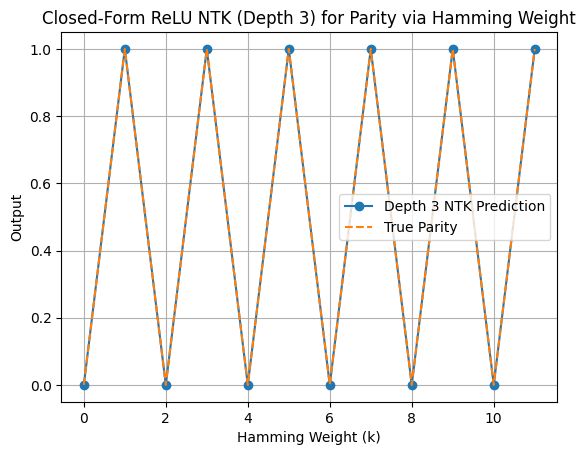

In [308]:
import numpy as np
import matplotlib.pyplot as plt

def relu_kernel(x, y):
    """Base ReLU kernel between two vectors x and y."""
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    dot = np.dot(x, y)
    cos_theta = dot / (norm_x * norm_y + 1e-10)
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return (norm_x * norm_y) * (np.sin(theta) + (np.pi - theta) * cos_theta) / np.pi

def deep_ntk(x, y, depth=3):
    """Recursive NTK kernel for fully connected ReLU network of given depth."""
    Sigma = relu_kernel(x, y)
    Theta = Sigma
    for _ in range(depth - 1):
        norm_xx = relu_kernel(x, x)
        norm_yy = relu_kernel(y, y)
        cos_theta = Theta / (np.sqrt(norm_xx * norm_yy) + 1e-10)
        theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        Sigma = (np.sqrt(norm_xx * norm_yy)) * (np.sin(theta) + (np.pi - theta) * cos_theta) / np.pi
        Theta += Sigma
    return Theta

# Create 11-bit binary vectors with k ones (Hamming weight)
n_bits = 11
depth = 3
X = []
ks = list(range(n_bits + 1))
for k in ks:
    x = np.zeros(n_bits)
    x[:k] = 1
    np.random.shuffle(x)
    X.append(x)

# Compute NTK matrix K and solve for parity
N = len(X)
K = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        K[i, j] = deep_ntk(X[i], X[j], depth=depth)

y = np.array([k % 2 for k in ks]).reshape(-1, 1)
alpha = np.linalg.pinv(K) @ y
preds = K @ alpha

# Plot
plt.plot(ks, preds.flatten(), marker='o', label=f'Depth {depth} NTK Prediction')
plt.plot(ks, [k % 2 for k in ks], linestyle='--', label='True Parity')
plt.xlabel("Hamming Weight (k)")
plt.ylabel("Output")
plt.title("Closed-Form ReLU NTK (Depth 3) for Parity via Hamming Weight")
plt.legend()
plt.grid(True)
plt.show()


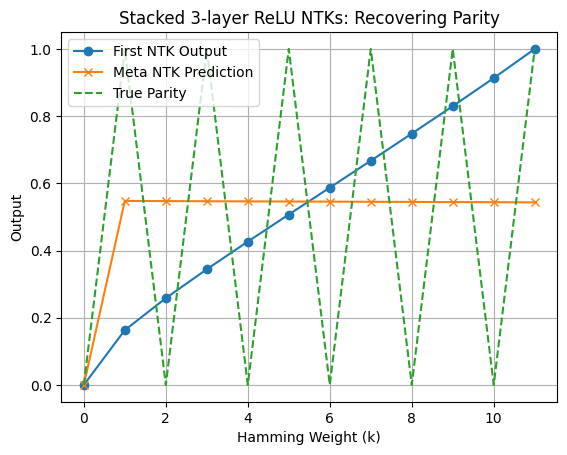

In [311]:
import numpy as np
import matplotlib.pyplot as plt

# ReLU kernel and 3-layer NTK recursion
def relu_kernel(x, y):
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    dot = np.dot(x, y)
    cos_theta = dot / (norm_x * norm_y + 1e-10)
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return (norm_x * norm_y) * (np.sin(theta) + (np.pi - theta) * cos_theta) / np.pi

def deep_ntk(x, y, depth=3):
    Sigma = relu_kernel(x, y)
    Theta = Sigma
    for _ in range(depth - 1):
        norm_xx = relu_kernel(x, x)
        norm_yy = relu_kernel(y, y)
        cos_theta = Theta / (np.sqrt(norm_xx * norm_yy) + 1e-10)
        theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        Sigma = (np.sqrt(norm_xx * norm_yy)) * (np.sin(theta) + (np.pi - theta) * cos_theta) / np.pi
        Theta += Sigma
    return Theta

# Inputs: 11-bit binary strings with k ones
n_bits = 11
depth = 3
ks = list(range(n_bits + 1))
X = []
Y = []

for k in ks:
    x = np.zeros(n_bits)
    x[:k] = 1
    np.random.shuffle(x)
    X.append(x)
    Y.append(k % 2)

X = np.array(X)
Y = np.array(Y).reshape(-1, 1)

# First NTK trained on only [0s] and [1s]
X_train_base = np.array([np.zeros(n_bits), np.ones(n_bits)])
Y_train_base = np.array([[0], [1]])

K_base = np.array([[deep_ntk(x1, x2, depth) for x2 in X_train_base] for x1 in X_train_base])
K_test = np.array([[deep_ntk(x, xt, depth) for xt in X_train_base] for x in X])
alpha_base = np.linalg.pinv(K_base) @ Y_train_base
base_preds = K_test @ alpha_base

# Second NTK trained on predictions → parity
meta_X = base_preds
meta_K = np.array([[deep_ntk(x1, x2, depth) for x2 in meta_X] for x1 in meta_X])
alpha_meta = np.linalg.pinv(meta_K) @ Y
meta_preds = meta_K @ alpha_meta

# Plot
plt.plot(ks, base_preds.flatten(), marker='o', label='First NTK Output')
plt.plot(ks, meta_preds.flatten(), marker='x', label='Meta NTK Prediction')
plt.plot(ks, Y.flatten(), linestyle='--', label='True Parity')
plt.xlabel("Hamming Weight (k)")
plt.ylabel("Output")
plt.title("Stacked 3-layer ReLU NTKs: Recovering Parity")
plt.legend()
plt.grid(True)
plt.show()


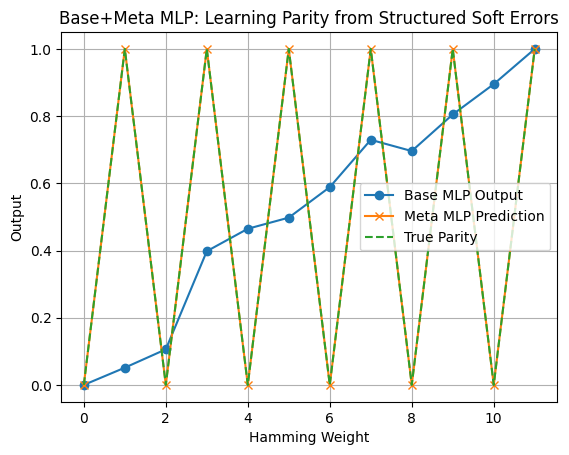

In [334]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Setup
n_bits = 11
torch.manual_seed(0)

# Generate training data for base model
x0 = torch.zeros(n_bits)
x1 = torch.ones(n_bits)
X_base = torch.stack([x0, x1])
y_base = torch.tensor([[0.], [1.]])

# Generate full dataset for meta-model
ks = list(range(n_bits + 1))
X_full, y_full = [], []
for k in ks:
    x = torch.zeros(n_bits)
    x[:k] = 1
    x = x[torch.randperm(n_bits)]
    X_full.append(x)
    y_full.append([k % 2])
X_full = torch.stack(X_full)
y_full = torch.tensor(y_full, dtype=torch.float32)

# Standard 2-layer ReLU MLP
class StandardMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)#, nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

# Train base model
base_model = StandardMLP(n_bits)
opt = optim.Adam(base_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss() #nn.BCELoss()

for _ in range(10000):
    y_pred = base_model(X_base)
    loss = loss_fn(y_pred, y_base)
    opt.zero_grad()
    loss.backward()
    opt.step()

# Generate soft predictions on 12 full inputs
with torch.no_grad():
    base_preds = base_model(X_full)

# Train meta model
meta_model = StandardMLP(1)
opt2 = optim.Adam(meta_model.parameters(), lr=0.001)
for _ in range(10000):
    y_pred = meta_model(base_preds)
    loss = loss_fn(y_pred, y_full)
    opt2.zero_grad()
    loss.backward()
    opt2.step()

# Evaluate and plot
with torch.no_grad():
    meta_preds = meta_model(base_preds).view(-1).tolist()

plt.plot(ks, base_preds.view(-1).tolist(), 'o-', label="Base MLP Output")
plt.plot(ks, meta_preds, 'x-', label="Meta MLP Prediction")
plt.plot(ks, [k % 2 for k in ks], '--', label="True Parity")
plt.xlabel("Hamming Weight")
plt.ylabel("Output")
plt.title("Base+Meta MLP: Learning Parity from Structured Soft Errors")
plt.grid(True)
plt.legend()
plt.show()


In [335]:
from itertools import product

# Step 1: Enumerate all 11-bit binary vectors
all_inputs = torch.tensor(list(product([0., 1.], repeat=n_bits)), dtype=torch.float32)

# Step 2: Feed through base model
with torch.no_grad():
    base_out = base_model(all_inputs)

# Step 3: Feed through meta model
with torch.no_grad():
    meta_out = meta_model(base_out)

# Step 4: Threshold and compute parity labels
pred_labels = (meta_out > 0.5).float().view(-1)
true_labels = all_inputs.sum(dim=1).int() % 2

# Step 5: Compute accuracy
accuracy = (pred_labels == true_labels).float().mean().item()
print(f"Full 11-bit generalization accuracy: {accuracy:.4f}")


Full 11-bit generalization accuracy: 0.5337
